# Code for the Pairs Trading Strategy

Developed by Subhransu S. Bhattacharjee for the Optiver Ph.D. Quant Lab Program, 2024

Website: [1ssb.github.io](https://1ssb.github.io)

Email: [Subhransu.Bhattacharjee@anu.edu.au](mailto:Subhransu.Bhattacharjee@anu.edu.au)

### First we need to install all the libraries needed for the entire project

In [2]:
%pip install pandas tqdm omegaconf black iopath pycocotools scikit-learn pykalman seaborn matplotlib statsmodels ta

/bin/bash: /home/users/u7143478/anaconda3/envs/ORB/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


### Data Loading and Preparation

This section of the code is responsible for loading the data from a CSV file, preprocessing it, and providing an initial overview of the dataset.

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path='data/final_data_10s.csv'):
    """
    Load data from a CSV file, parse the 'Time' column to datetime, and set it as the index.

    Parameters:
    file_path (str): The path to the CSV file containing the data.

    Returns:
    pd.DataFrame: The preprocessed data with 'Time' as the index.
    """
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')  # Parse 'Time' column to datetime
    df.dropna(subset=['Time'], inplace=True)  # Drop rows with invalid 'Time' values
    df.set_index('Time', inplace=True)  # Set 'Time' as the index
    print(f"DataFrame loaded with {df.shape[0]} rows and {df.shape[1]} columns.")  # Print the shape of the DataFrame
    return df

# Load the DataFrame
df = load_data()
df.index = pd.to_datetime(df.index)  # Ensure the index is in datetime format

# Display the first few rows of the DataFrame
print(df.head())

# Display a summary of the DataFrame's statistics
print(df.describe())

Dataset loaded with 737739 rows and 8 columns.
                        X_BID  X_BID_VOL     X_ASK  X_ASK_VOL     Y_BID  \
Time                                                                      
2019-11-18 08:00:00  106340.0       15.0  106348.0       11.0  105200.0   
2019-11-18 08:00:10  106312.0        6.0  106320.0        9.0  105180.0   
2019-11-18 08:00:20  106312.0        7.0  106320.0       12.0  105170.0   
2019-11-18 08:00:30  106336.0       22.0  106340.0        1.0  105190.0   
2019-11-18 08:00:40  106352.0        2.0  106356.0        4.0  105200.0   

                     Y_BID_VOL     Y_ASK  Y_ASK_VOL  
Time                                                 
2019-11-18 08:00:00        9.0  105210.0       19.0  
2019-11-18 08:00:10        5.0  105190.0       13.0  
2019-11-18 08:00:20       32.0  105180.0        1.0  
2019-11-18 08:00:30       10.0  105200.0       19.0  
2019-11-18 08:00:40       29.0  105220.0       24.0  
               X_BID      X_BID_VOL          X_AS

We have 8 columns and the summary of the dataset. There are 737739 datapoints with 10 seconds' timestamps.

Instruments X and Y do *not* trade 24 hours a day, nor at all times, need to keep this in mind in financial metric computations.

### Validating the correlations

Correlation Matrix:
               X_BID  X_BID_VOL     X_ASK  X_ASK_VOL     Y_BID  Y_BID_VOL  \
X_BID      1.000000  -0.100079  0.999997   0.081609  0.978944   0.062361   
X_BID_VOL -0.100079   1.000000 -0.100189   0.030392 -0.087304   0.011525   
X_ASK      0.999997  -0.100189  1.000000   0.081370  0.978902   0.062100   
X_ASK_VOL  0.081609   0.030392  0.081370   1.000000  0.078297   0.047101   
Y_BID      0.978944  -0.087304  0.978902   0.078297  1.000000   0.055931   
Y_BID_VOL  0.062361   0.011525  0.062100   0.047101  0.055931   1.000000   
Y_ASK      0.978955  -0.087409  0.978917   0.077899  0.999996   0.056046   
Y_ASK_VOL  0.048193  -0.026351  0.047890   0.066008  0.055853   0.099351   
spread    -0.691199   0.107355 -0.691357  -0.061054 -0.529140  -0.060114   

              Y_ASK  Y_ASK_VOL    spread  
X_BID      0.978955   0.048193 -0.691199  
X_BID_VOL -0.087409  -0.026351  0.107355  
X_ASK      0.978917   0.047890 -0.691357  
X_ASK_VOL  0.077899   0.066008 -0.061054  
Y_B

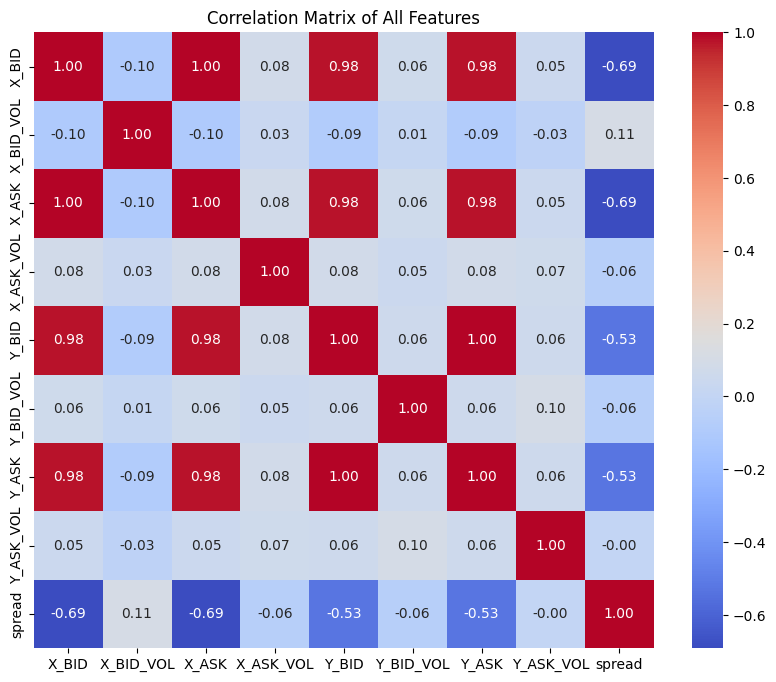

In [3]:
import seaborn as sns

# Detailed Correlation Matrix
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features')
plt.show()

Here we find that the instruments understudy are quite correlated to 0.98 positive correlation.

### Simple Moving Averages Calculation and Visualization

In this section, we calculate the simple moving averages (SMA) for both assets and visualize them alongside the original prices.

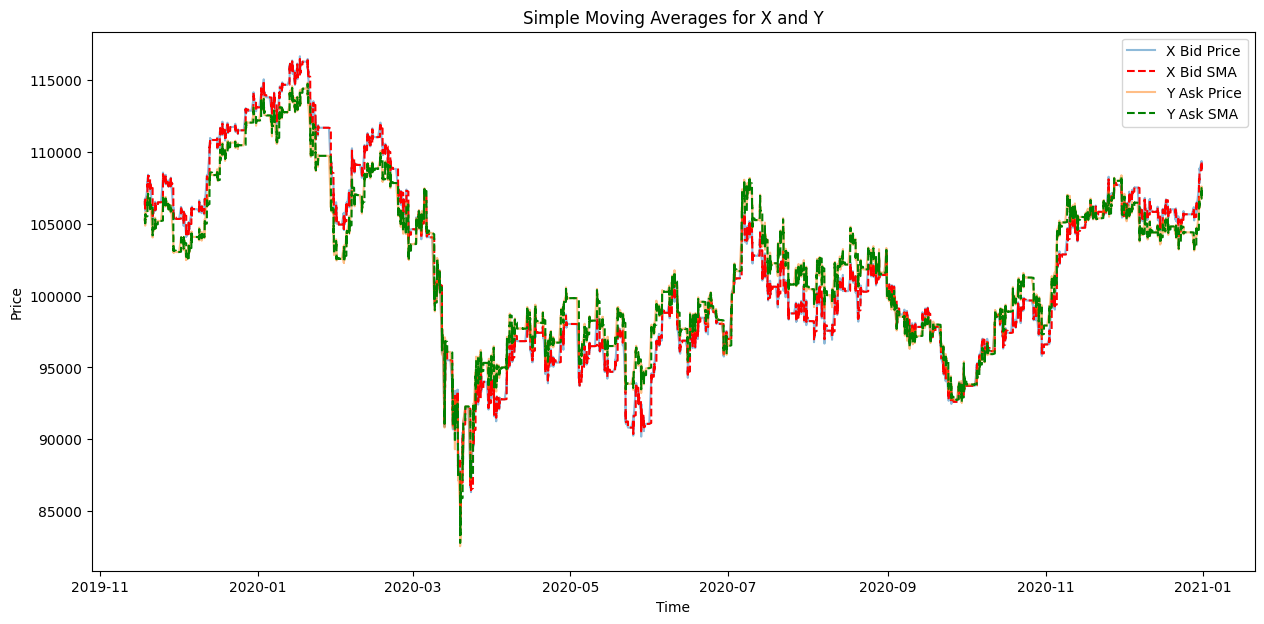

In [61]:
# Calculate simple moving averages for both assets
window_size = 50  # Change the window size based on your analysis needs
df['X_BID_SMA'] = df['X_BID'].rolling(window=window_size).mean()
df['Y_ASK_SMA'] = df['Y_ASK'].rolling(window=window_size).mean()

# Plotting the moving averages along with the original prices
plt.figure(figsize=(15, 7))
plt.plot(df['X_BID'], label='X Bid Price', alpha=0.5)
plt.plot(df['X_BID_SMA'], label='X Bid SMA', color='red', linestyle='--')
plt.plot(df['Y_ASK'], label='Y Ask Price', alpha=0.5)
plt.plot(df['Y_ASK_SMA'], label='Y Ask SMA', color='green', linestyle='--')
plt.title('Simple Moving Averages for X and Y')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


This visualization helps to understand the trends in the bid and ask prices over time and how the moving averages smooth out short-term fluctuations. The dataset covers more than one year, and our primary trading period will focus on data from 2020.

Given the relatively short time frame of our dataset (approximately one year), it would be prudent to employ simpler statistical methods for our trading strategies. My initial idea of using deep learning models, which while powerful, typically require much larger datasets to perform effectively. Therefore, for this time frame, simpler methods like moving averages and other technical indicators are more suitable and can be effectively backtested and implemented with the available data.

## Pairs Analysis

The price spread indicates the absolute difference between the ask price of asset Y and the bid price of asset X. This can be useful for identifying arbitrage opportunities or understanding the market dynamics between these two assets.

By visualizing these metrics, we can gain insights into the market behavior over time, identify potential trading signals, and better understand the interaction between the two assets. 

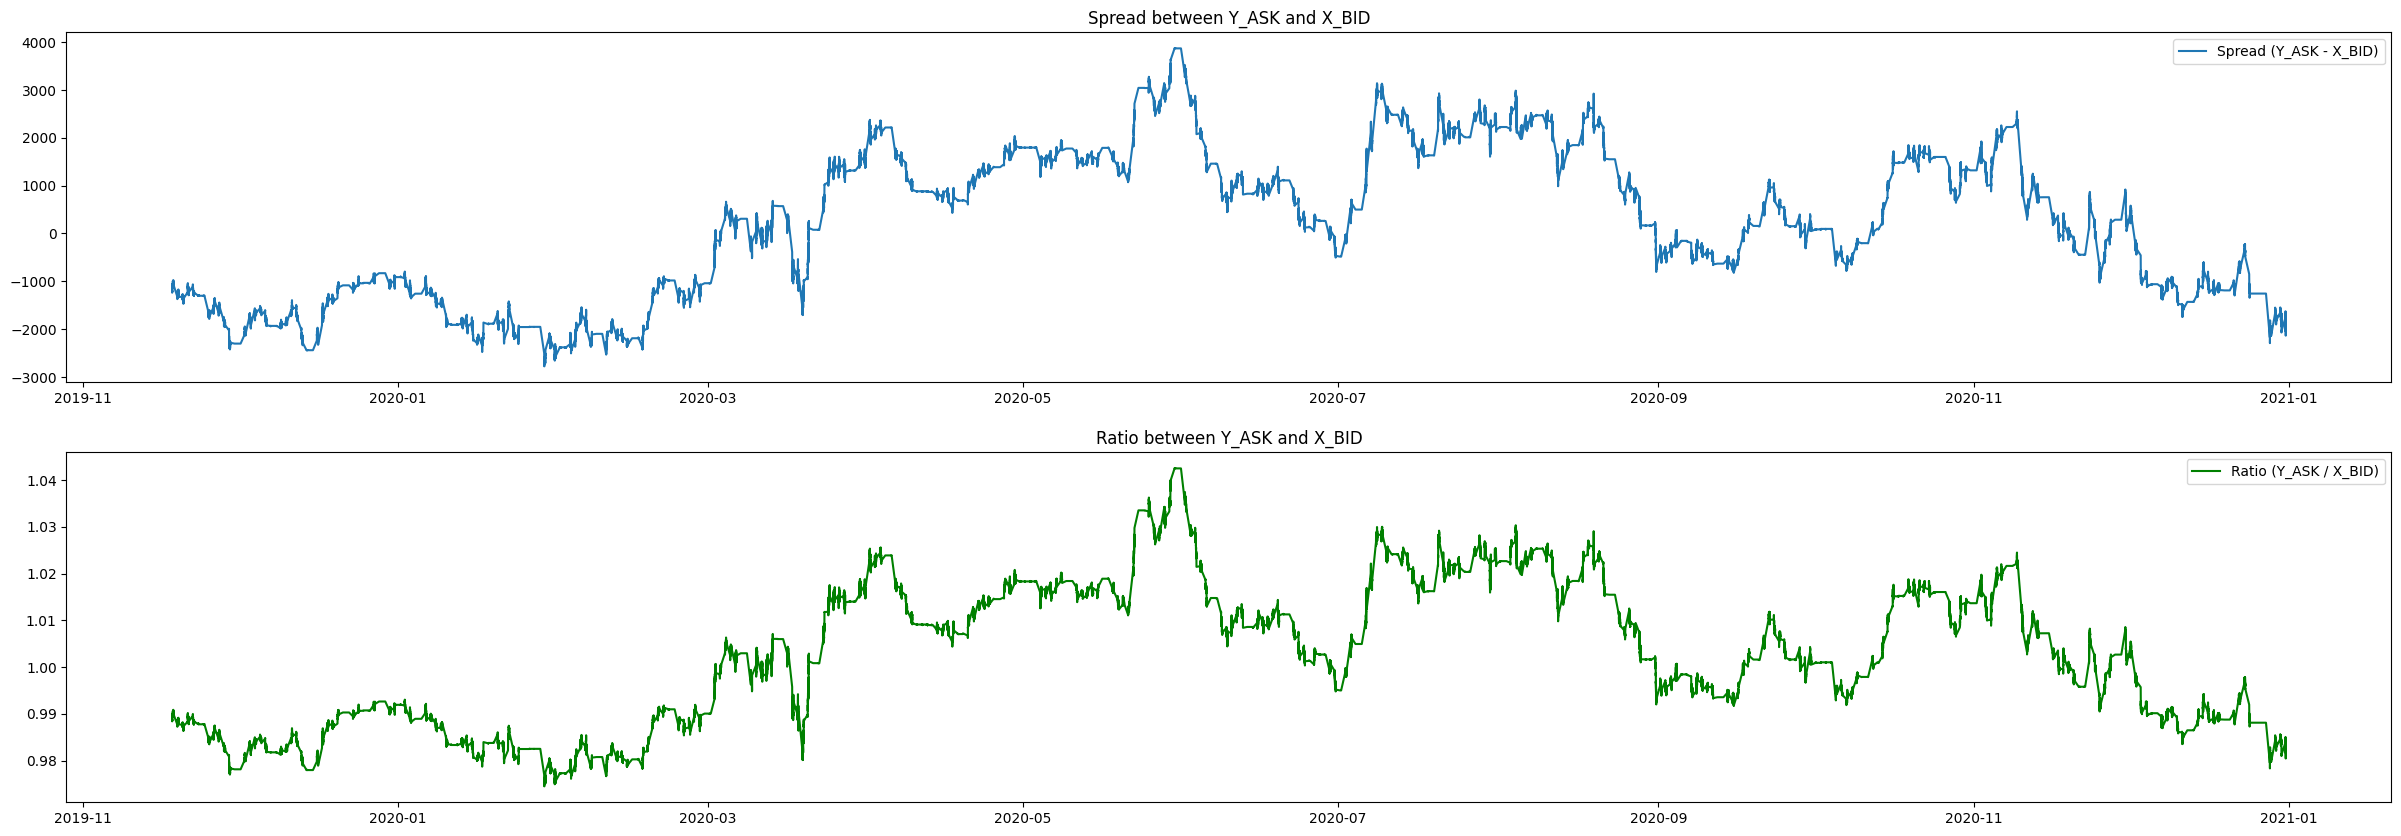

In [5]:
# Calculate the price spread and ratio
df['Spread_1'] = df['Y_ASK'] - df['X_BID']
df['Ratio_1'] = df['Y_ASK'] / df['X_BID']

# Plotting the spread and ratio
plt.figure(figsize=(30, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Spread_1'], label='Spread (Y_ASK - X_BID)')
plt.title('Spread between Y_ASK and X_BID')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Ratio_1'], label='Ratio (Y_ASK / X_BID)', color='green')
plt.title('Ratio between Y_ASK and X_BID')
plt.legend()
plt.show()

We continue with the other counterpart to identify what other opportunities could be out there. This part is for pattern detection i.e. if some pairs are more exploitable than the other.

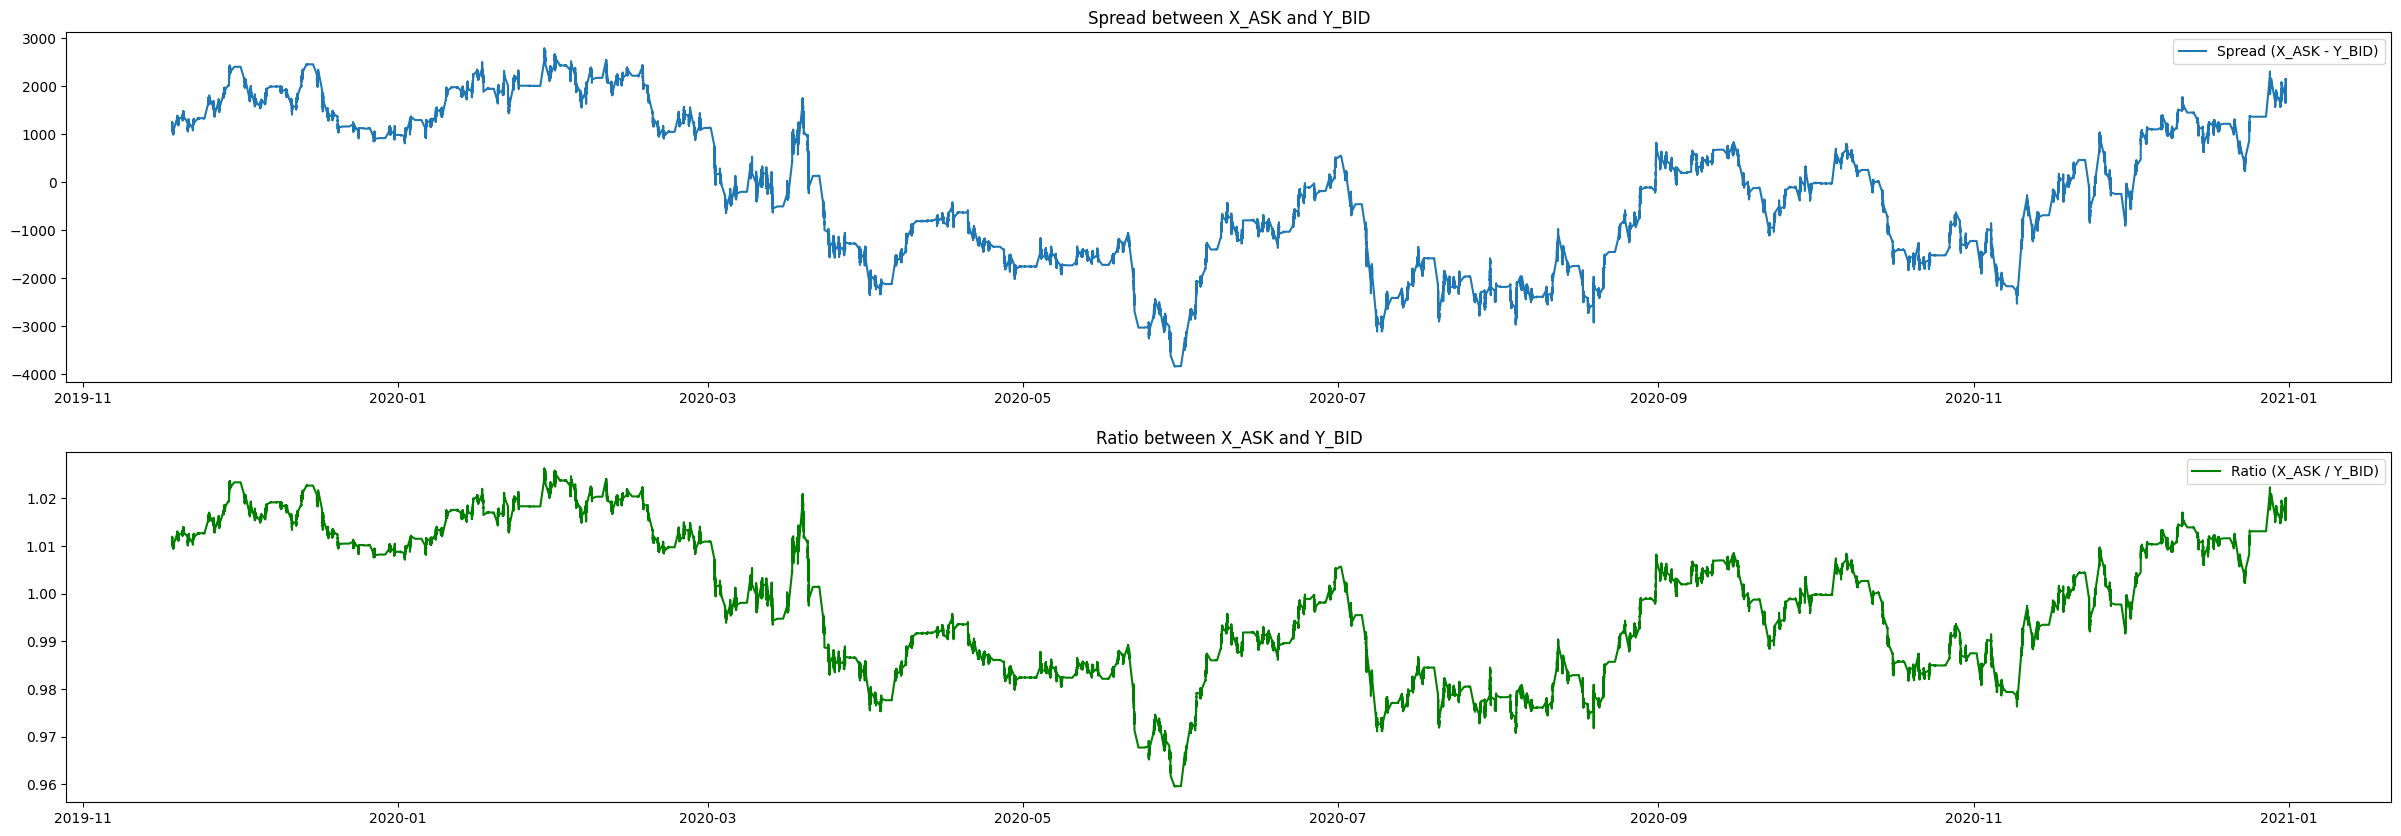

In [6]:
# Calculate the price spread and ratio
df['Spread_2'] = df['X_ASK'] - df['Y_BID']
df['Ratio_2'] = df['X_ASK'] / df['Y_BID']

# Plotting the spread and ratio
plt.figure(figsize=(30, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Spread_2'], label='Spread (X_ASK - Y_BID)')
plt.title('Spread between X_ASK and Y_BID')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Ratio_2'], label='Ratio (X_ASK / Y_BID)', color='green')
plt.title('Ratio between X_ASK and Y_BID')
plt.legend()
plt.show()

Interestingly, the spread and the ratios are visually complementary. When the spread between X_BID and Y_ASK increases, the spread between X_ASK and Y_BID decreases. This inverse relationship can provide further insights into market movements and help in developing robust trading strategies.

The price ratio provides a relative measure of the relationship between the ask price of asset Y and the bid price of asset X. It can highlight proportional changes and trends that might not be evident from the spread alone. The inverse relationship suggests that the market adjusts quickly to price differences between the two assets, maintaining a form of efficiency. When one spread widens, the other narrows, indicating arbitrageurs may be active in balancing the prices. A strong inverse relationship indicates that these assets are highly correlated, but in opposite directions, which is crucial for pairs trading strategies.

#### My Note: 

One of the most interesting things that fascinated me since undergrad stats was the concept of p-value in statistics. Statisticians seem to be heavily relying on this to make so many decisions. The null hypothesis is just a fancy way of saying there is no basis to our understanding that there isan underlying pattern and if thing come out to be statistically significant enough then we reject that null hypothesis. A very small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so it is rejected. A large p-value suggests that the observed data are consistent with the null hypothesis.

#### Stationary and Cointegration Tests

 - Stationary Tests: These tests are critical for time series analysis, as many statistical methods require that a series be stationary to make valid inferences. The p-value in a stationary test (like the ADF test) tells us whether the time series has a unit root, meaning it is non-stationary. Rejecting the null hypothesis implies that the series does not have a unit root and is stationary.

 - Cointegration Tests: When dealing with multiple time series, cointegration tests like the Engle-Granger test assess whether there is a long-term equilibrium relationship between them. The p-value helps determine whether we can reject the null hypothesis that no cointegration exists, indicating that despite short-term deviations, the series move together over the long term.

### Stationarity Testing with Augmented Dickey-Fuller (ADF) Test

In this section, we perform the Augmented Dickey-Fuller (ADF) test to check the stationarity of the price spread and ratio. Stationarity is a crucial property for time series data, indicating that the statistical properties (mean, variance) are constant over time. Stationary series are essential for many time series forecasting and trading strategies. If either the spread or the ratio is not stationary, it suggests that the statistical properties of the series change over time, which may require different modeling approaches, such as differencing the series or using more complex modelling.

In [7]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the spread
adf_result_spread = adfuller(df['Spread_1'])
print(f"ADF Statistic for Spread: {adf_result_spread[0]}")
print(f"p-value for Spread: {adf_result_spread[1]}")
if adf_result_spread[1] < 0.05:
    print("Spread is stationary")
else:
    print("Spread is not stationary")

# Perform ADF test on the ratio
adf_result_ratio = adfuller(df['Ratio_1'])
print(f"ADF Statistic for Ratio: {adf_result_ratio[0]}")
print(f"p-value for Ratio: {adf_result_ratio[1]}")
if adf_result_ratio[1] < 0.05:
    print("Ratio is stationary")
else:
    print("Ratio is not stationary")

ADF Statistic for Spread: -1.932569521824092
p-value for Spread: 0.3168978590464976
Spread is not stationary
ADF Statistic for Ratio: -1.9960023662693398
p-value for Ratio: 0.28832866848232364
Ratio is not stationary



- Non-Stationary Spread:

  - The p-value of 0.3168978590464976 is greater than 0.05, indicating that we cannot reject the null hypothesis. Thus, the spread between Y_ASK and X_BID is not stationary.
  - This implies that the difference between these two prices does not have a consistent mean or variance over time, making it unsuitable for strategies that rely on mean-reverting properties.

- Non-Stationary Ratio:

  - The p-value of 0.28832866848232364 is greater than 0.05, indicating that we cannot reject the null hypothesis. Thus, the ratio between Y_ASK and X_BID is not stationary.
  - This suggests that the proportional relationship between these two prices does not have consistent statistical properties over time, complicating the use of mean-reversion strategies.

In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the spread
adf_result_spread = adfuller(df['Spread_2'])
print(f"ADF Statistic for Spread: {adf_result_spread[0]}")
print(f"p-value for Spread: {adf_result_spread[1]}")
if adf_result_spread[1] < 0.05:
    print("Spread is stationary")
else:
    print("Spread is not stationary")

# Perform ADF test on the ratio
adf_result_ratio = adfuller(df['Ratio_2'])
print(f"ADF Statistic for Ratio: {adf_result_ratio[0]}")
print(f"p-value for Ratio: {adf_result_ratio[1]}")
if adf_result_ratio[1] < 0.05:
    print("Ratio is stationary")
else:
    print("Ratio is not stationary")

ADF Statistic for Spread: -1.9283948656721592
p-value for Spread: 0.31882340548443855
Spread is not stationary
ADF Statistic for Ratio: -1.982967081166958
p-value for Ratio: 0.2940910130358628
Ratio is not stationary


Interestingly, this observation is similar to the previous one. This indeed discourages us from mean reversion strategies, which is possibly not a good idea. These instruments might need something a bit more more sophisticated. 

By the way, I explored several strategies to trade one asset by looking at the parameters of two, rather than engaging in pairs trading. All of these strategies yielded good results using machine learning models. While this approach is unconventional, it can be successful in certain contexts, especially when you don't have enough capital to invest or when pairs trading is not feasible.

Even with limited capital, a well-designed machine learning model can manage a portfolio of stocks, optimizing for returns while managing risk without the need for large-scale investments. However, more complex algorithms might capture subtle nuances in the data but could also become less interpretable and harder to manage. This was my experience, so some strategies ended up in the "failed_attempts" folder (I tried 26 of them).

## Cointegration Testing

In this section, we perform a cointegration test to determine whether the price series of two assets (X_BID and Y_ASK) move together in the long run. Cointegration is crucial for pairs trading strategies as it indicates a stable, long-term relationship between the two assets. For pairs trading strategies, cointegration is essential as it indicates that the price series' will revert to a common mean over time, providing trading opportunities when they deviate from this equilibrium.


In [9]:
from statsmodels.tsa.stattools import coint

# Perform Cointegration test
coint_t, p_value, crit_value = coint(df['X_BID'], df['Y_ASK'])
print(f"Cointegration test statistic: {coint_t}")
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("X_BID and Y_ASK are cointegrated")
else:
    print("X_BID and Y_ASK are not cointegrated")

Cointegration test statistic: -3.080795167784318
p-value: 0.0922255694069204
X_BID and Y_ASK are not cointegrated


The p-value of 0.092 indicates that we cannot reject the null hypothesis of no cointegration at the 5% significance level. Therefore, X_BID and Y_ASK are not cointegrated. This result implies that there is no stable long-term relationship between the prices of these two assets. They do not move together in the long run, which suggests that pairs trading strategies based on the assumption of cointegration might not be suitable for these assets.

In [10]:
from statsmodels.tsa.stattools import coint

# Perform Cointegration test
coint_t, p_value, crit_value = coint(df['Y_BID'], df['X_ASK'])
print(f"Cointegration test statistic: {coint_t}")
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Y_BID and X_ASK are cointegrated")
else:
    print("Y_BID and X_ASK are not cointegrated")

Cointegration test statistic: -3.3672884933141107
p-value: 0.04611583845056178
Y_BID and X_ASK are cointegrated


#### Pairs Trading Opportunity:

The cointegration of Y_BID and X_ASK suggests that these two assets move together in the long run. This will be from hereon our target representation for our pair trades.

#### Why Perform Cointegration Test if Spread and Ratios are Not Stationary in the first place?

While the spread and ratio being non-stationary might suggest that they don't revert to a mean over time, it's still essential to perform the cointegration test between the original series (X_BID and Y_ASK) because:

- Long-Term Relationship: Cointegration focuses on finding a long-term equilibrium relationship between two or more non-stationary series. Even if individual series or their derived measures (spread and ratio) are non-stationary, they may still move together over the long term.

- Pairs Trading Viability: If two assets are cointegrated, it indicates that they have a long-term stable relationship. This is crucial for pairs trading strategies, which exploit deviations from this equilibrium to generate profits.

- Error Correction Model: Cointegrated series can be modeled using an Error Correction Model (ECM) to capture both short-term deviations and long-term equilibrium adjustments. This approach can still be valid even when the spread or ratio alone doesn't show stationarity.

By performing the cointegration test and understanding its results, we can make informed decisions about the suitability of pairs trading strategies and identify potential trading opportunities based on the long-term relationship between the assets. Even if the spread and ratio are not stationary, the underlying series might still exhibit cointegration, which is valuable for developing robust trading strategies. Just like it did for us!

### Anomaly Detection

Anomalies often give us understanding of the data which can be exploited for comprehensively understanding the windows of opportunities. Literally.

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

# Set plot style
sns.set_theme(style="whitegrid")


### Z-score Method for Anomaly Detection

Z-score standardizes the data to have a mean of 0 and a standard deviation of 1, which helps in identifying how far a data point is from the mean. Points with Z-scores above or below a certain threshold (here, 3) are considered anomalies.

In [14]:
# Calculate Z-scores for all columns
columns = ['X_BID', 'X_BID_VOL', 'X_ASK', 'X_ASK_VOL', 'Y_BID', 'Y_BID_VOL', 'Y_ASK', 'Y_ASK_VOL']
for col in columns:
    df[f'{col}_Z'] = zscore(df[col])

# Identify anomalies with Z-score threshold
z_threshold = 3
for col in columns:
    df[f'{col}_ANOMALY_Z'] = df[f'{col}_Z'].apply(lambda x: x > z_threshold or x < -z_threshold)

# Display the anomalies detected by Z-score method
df[[f'{col}_ANOMALY_Z' for col in columns]].sum()


X_BID_ANOMALY_Z            0
X_BID_VOL_ANOMALY_Z     3852
X_ASK_ANOMALY_Z            0
X_ASK_VOL_ANOMALY_Z     5227
Y_BID_ANOMALY_Z         1582
Y_BID_VOL_ANOMALY_Z     7270
Y_ASK_ANOMALY_Z         1590
Y_ASK_VOL_ANOMALY_Z    10704
dtype: int64

##### IQR Method for Anomaly Detection

The interquartile range (IQR) is used to measure statistical dispersion, and points outside 1.5 times the IQR from the quartiles are considered outliers.

In [15]:
# Calculate IQR for all columns
Q1 = df[columns].quantile(0.25)
Q3 = df[columns].quantile(0.75)
IQR = Q3 - Q1

# Identify anomalies with IQR method
for col in columns:
    df[f'{col}_ANOMALY_IQR'] = ((df[col] < (Q1[col] - 1.5 * IQR[col])) | (df[col] > (Q3[col] + 1.5 * IQR[col])))

# Display the anomalies detected by IQR method
df[[f'{col}_ANOMALY_IQR' for col in columns]].sum()


X_BID_ANOMALY_IQR            0
X_BID_VOL_ANOMALY_IQR    29305
X_ASK_ANOMALY_IQR            0
X_ASK_VOL_ANOMALY_IQR    26825
Y_BID_ANOMALY_IQR         1802
Y_BID_VOL_ANOMALY_IQR    24867
Y_ASK_ANOMALY_IQR         1802
Y_ASK_VOL_ANOMALY_IQR    23683
dtype: int64

##### Isolation Forest for Anomaly Detection

An unsupervised learning algorithm that isolates anomalies by randomly selecting features and splitting values between maximum and minimum values. It is effective for high-dimensional data. Specifies the proportion of outliers in the data, helping the model to identify anomalies effectively.

In [18]:
# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['ISO_FOREST_ANOMALY'] = iso_forest.fit_predict(df[columns])

# Convert anomaly labels to boolean
df['ISO_FOREST_ANOMALY'] = df['ISO_FOREST_ANOMALY'].apply(lambda x: True if x == -1 else False)

# Display the number of anomalies detected by Isolation Forest
print("Total numberof anomalies detected:", df['ISO_FOREST_ANOMALY'].sum())

Total numberof anomalies detected: 6117


#### Visualization of Anomalies

Plotting Anomalies Detected by Z-score, IQR Methods, and Isolation Forest

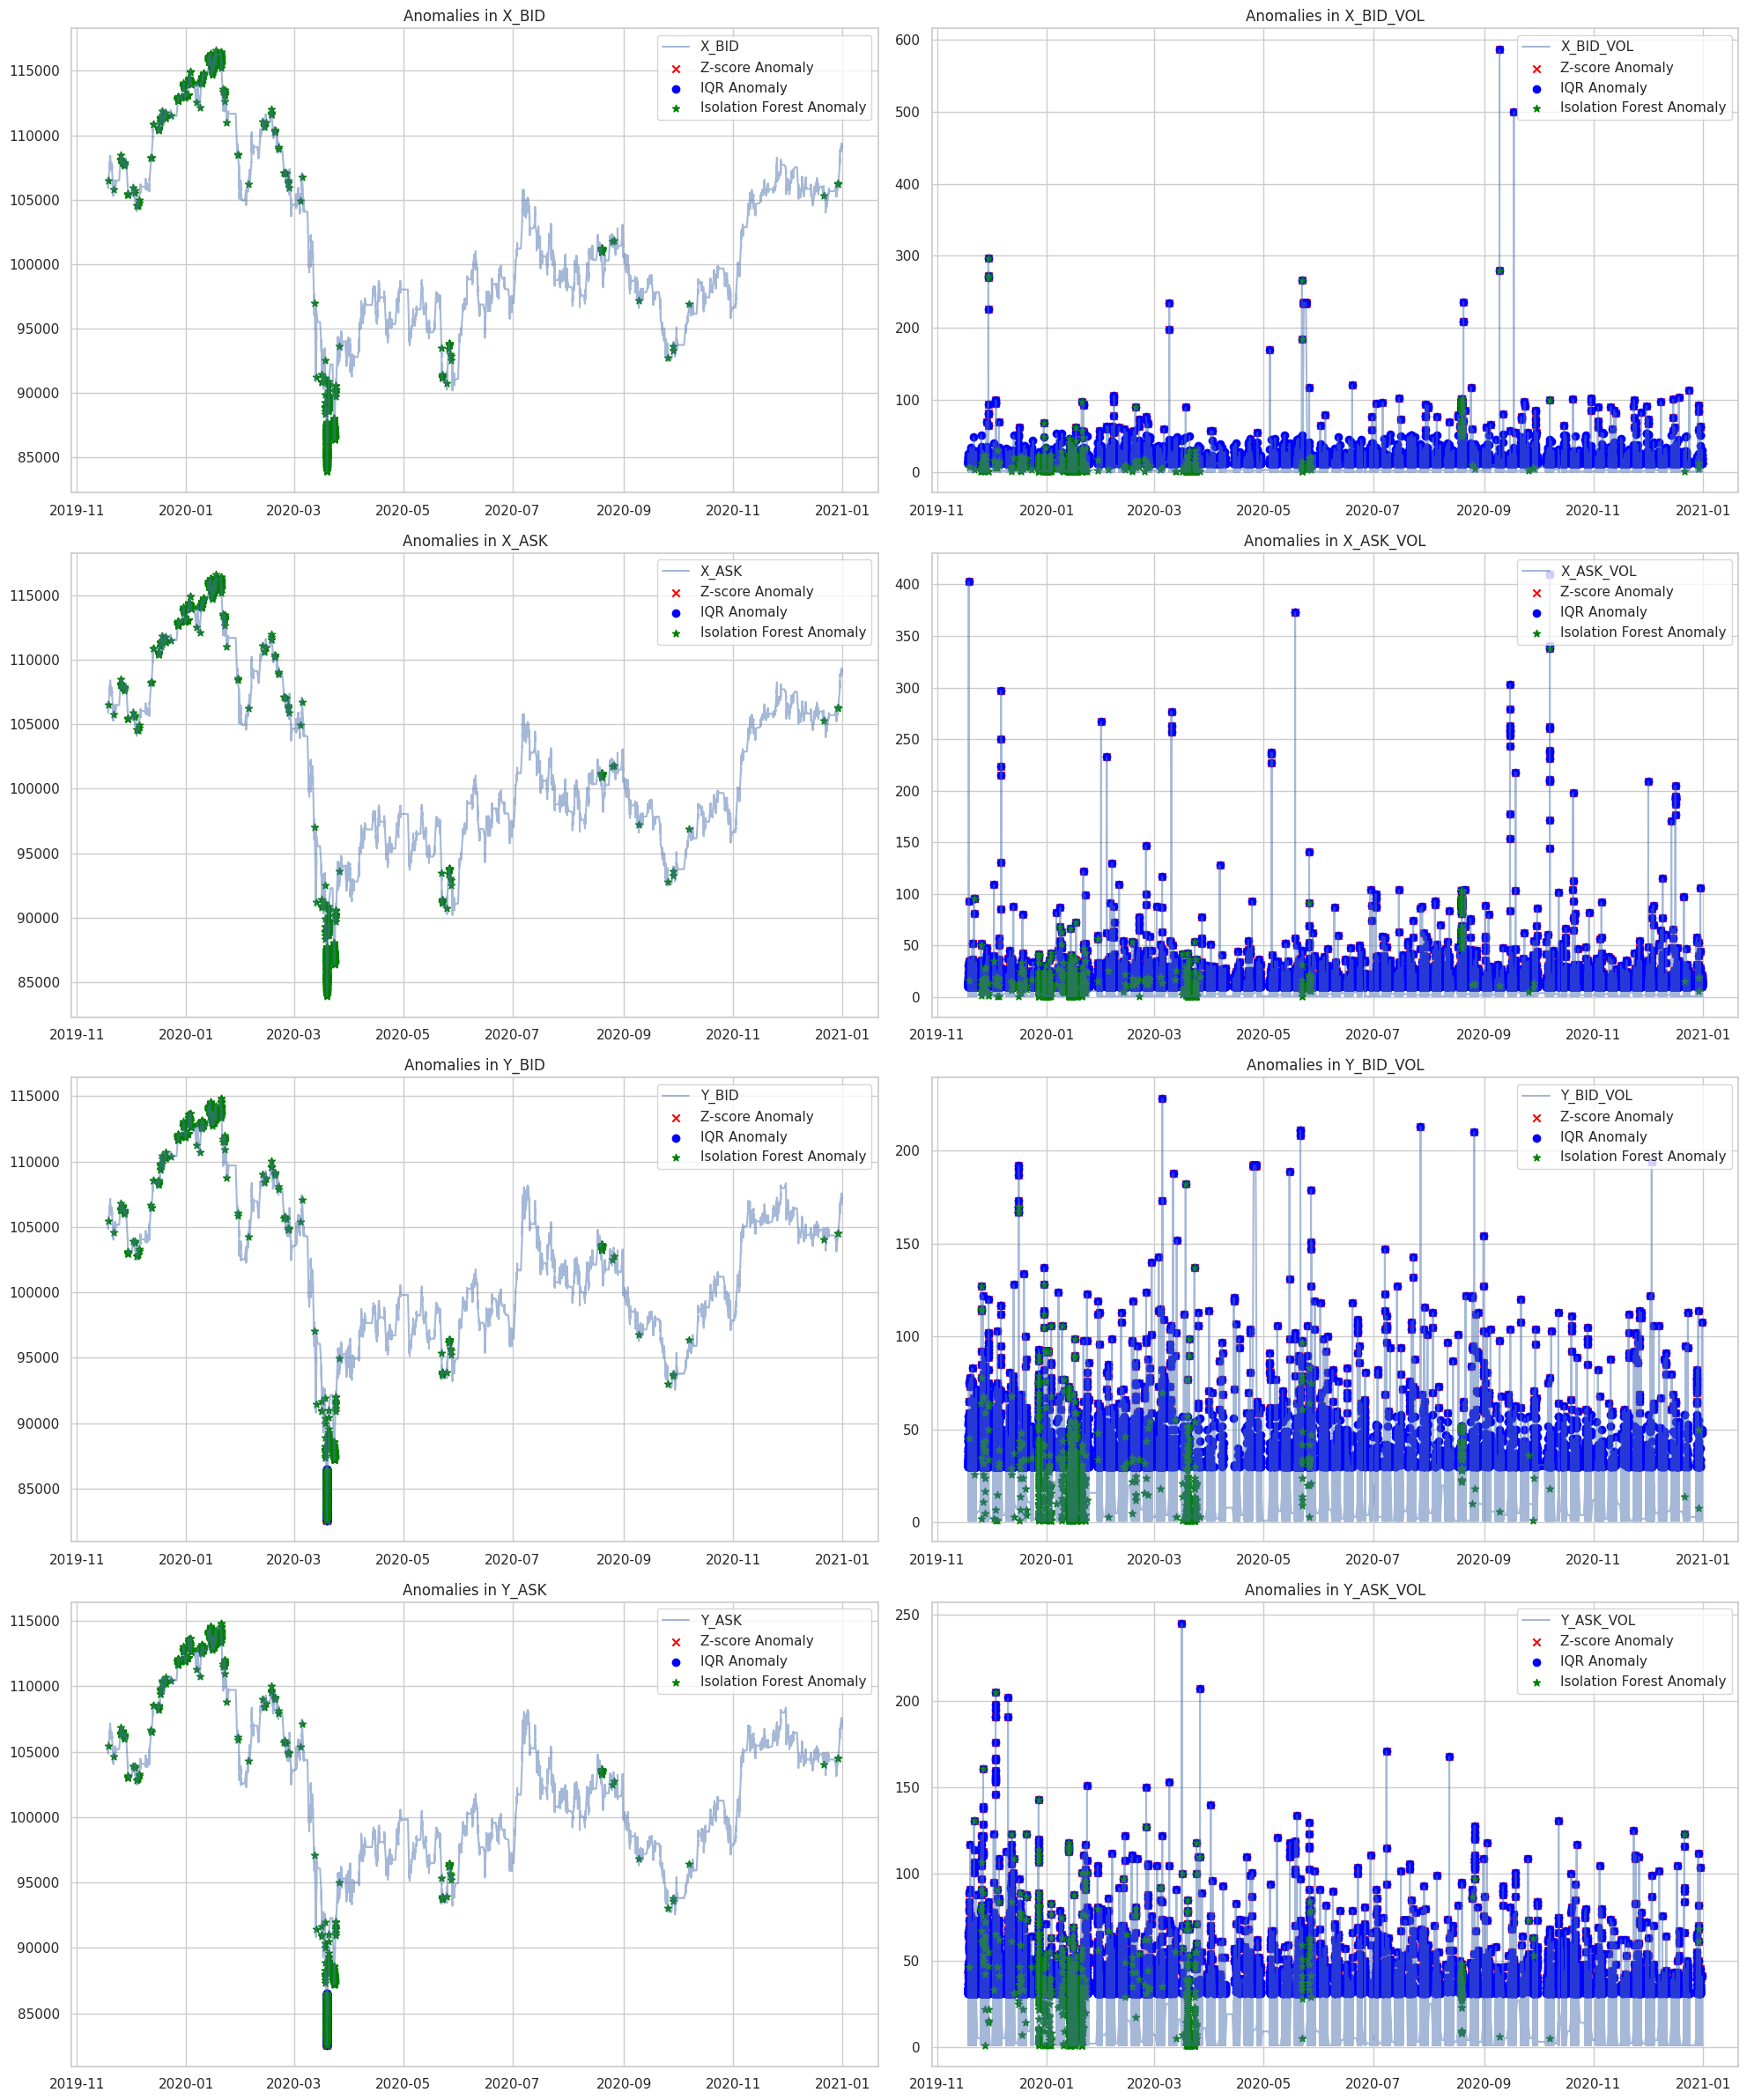

In [19]:
plt.figure(figsize=(20, 24))

for i, col in enumerate(columns):
    plt.subplot(4, 2, i+1)
    plt.plot(df[col], label=col, alpha=0.5)
    plt.scatter(df.index[df[f'{col}_ANOMALY_Z']], df[df[f'{col}_ANOMALY_Z']][col], color='red', label='Z-score Anomaly', marker='x')
    plt.scatter(df.index[df[f'{col}_ANOMALY_IQR']], df[df[f'{col}_ANOMALY_IQR']][col], color='blue', label='IQR Anomaly', marker='o')
    plt.scatter(df.index[df['ISO_FOREST_ANOMALY']], df[df['ISO_FOREST_ANOMALY']][col], color='green', label='Isolation Forest Anomaly', marker='*')
    plt.title(f'Anomalies in {col}')
    plt.legend()

plt.tight_layout()
plt.show()

### Insights from Statistical Anomaly Detection Visualizations

The visualizations provided show the anomalies detected in the bid and ask prices and volumes for both X and Y using three different methods: Z-score, IQR method, and Isolation Forest. Here are the detailed insights from these visualizations:

#### Anomalies in Prices (`X_BID`, `X_ASK`, `Y_BID`, `Y_ASK`)

1. **Common Patterns in Anomalies**:
   - **Observation**: The anomalies detected by the Z-score, IQR, and Isolation Forest methods are mostly clustered around certain periods, particularly in early 2020.
   - **Insight**: This clustering suggests that there were significant market events or increased volatility during these periods, leading to abnormal price behavior. These events could be market crashes, economic news, or other external factors influencing the market.

2. **Method Comparison**:
   - **Observation**: The Z-score method detects fewer anomalies compared to the IQR method and Isolation Forest. The IQR method and Isolation Forest show a larger number of anomalies, indicating their sensitivity to deviations.
   - **Insight**: The Z-score method might be missing some subtle anomalies due to its reliance on standard deviations from the mean, whereas the IQR method and Isolation Forest are more robust in detecting a wider range of anomalies, including outliers and distributional changes.

3. **Market Dynamics**:
   - **Observation**: The detected anomalies align with significant price movements, especially during periods of sharp declines or spikes.
   - **Insight**: The alignment of anomalies with major price movements underscores the effectiveness of these methods in capturing significant market changes. This is crucial for traders to identify and respond to abnormal market conditions.

#### Anomalies in Volumes (`X_BID_VOL`, `X_ASK_VOL`, `Y_BID_VOL`, `Y_ASK_VOL`)

1. **Volume Spikes**:
   - **Observation**: The volume anomalies are frequent and exhibit large spikes, especially in early 2020.
   - **Insight**: These volume spikes indicate periods of high trading activity, which could be driven by market news, large trades, or liquidity changes. High volumes often accompany significant price movements, suggesting heightened market interest or stress.

2. **Sensitivity of Detection Methods**:
   - **Observation**: The Isolation Forest method detects the highest number of anomalies, followed by the IQR method, with the Z-score method detecting the least.
   - **Insight**: Isolation Forest’s ability to handle high-dimensional data and detect complex anomalies makes it particularly effective for volume data. The IQR method's robustness to skewed distributions also captures a wide range of anomalies, while the Z-score method’s reliance on standard deviations might miss more subtle changes.

### Summary Statistics of the Entire Dataset

We visualize the entire dataset for patterns.

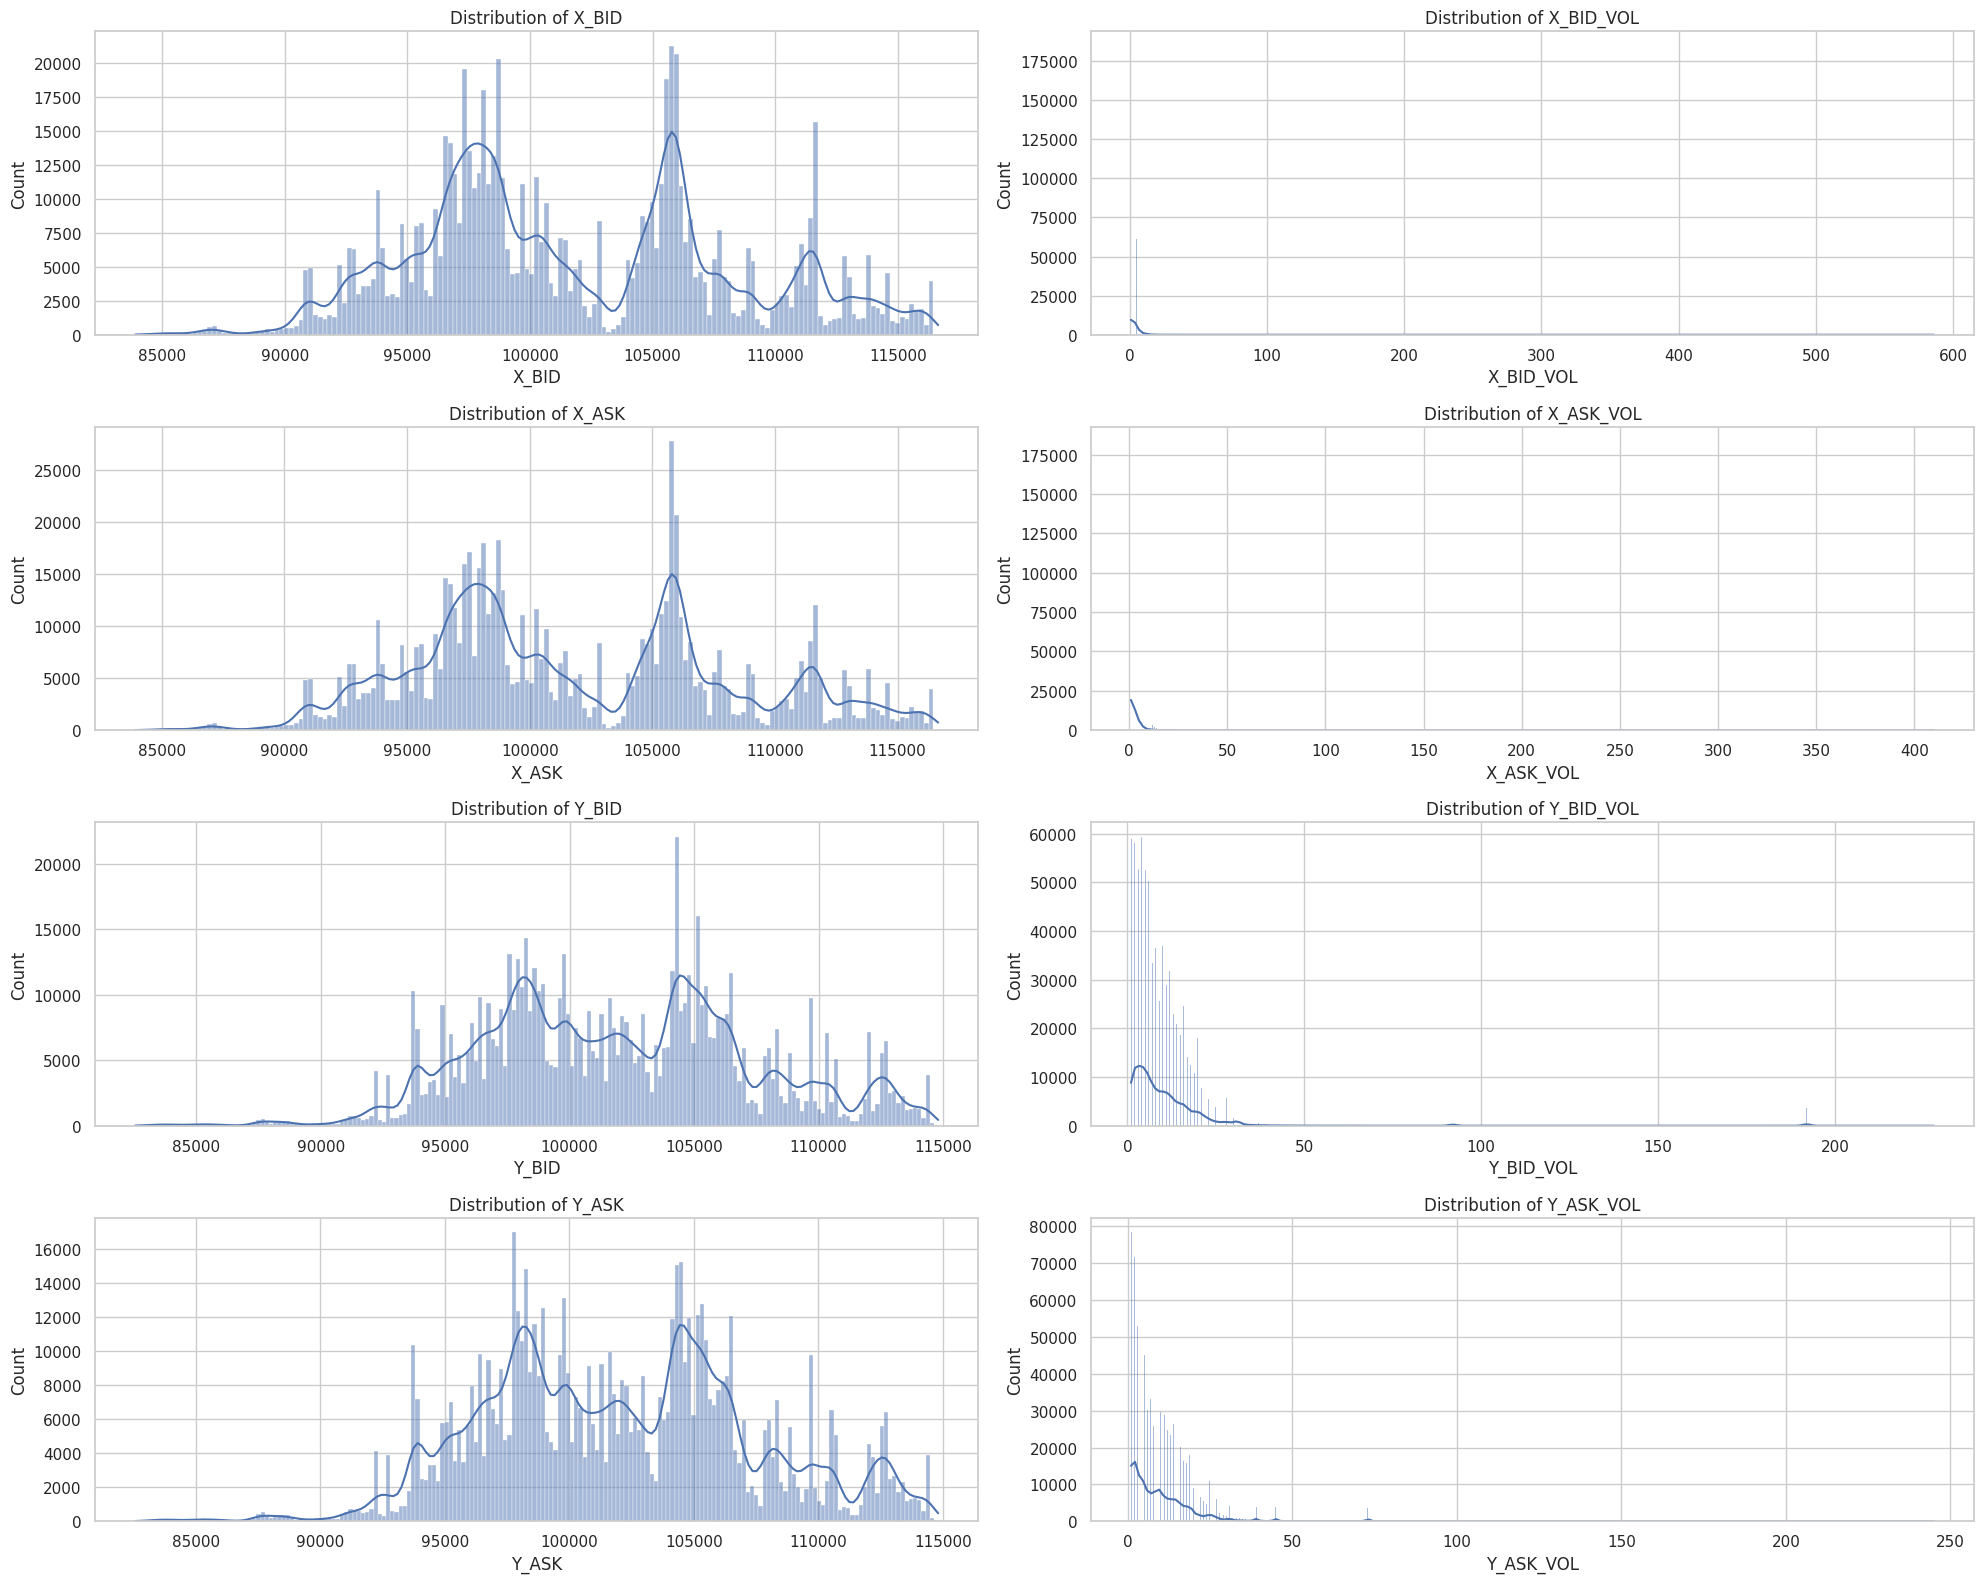

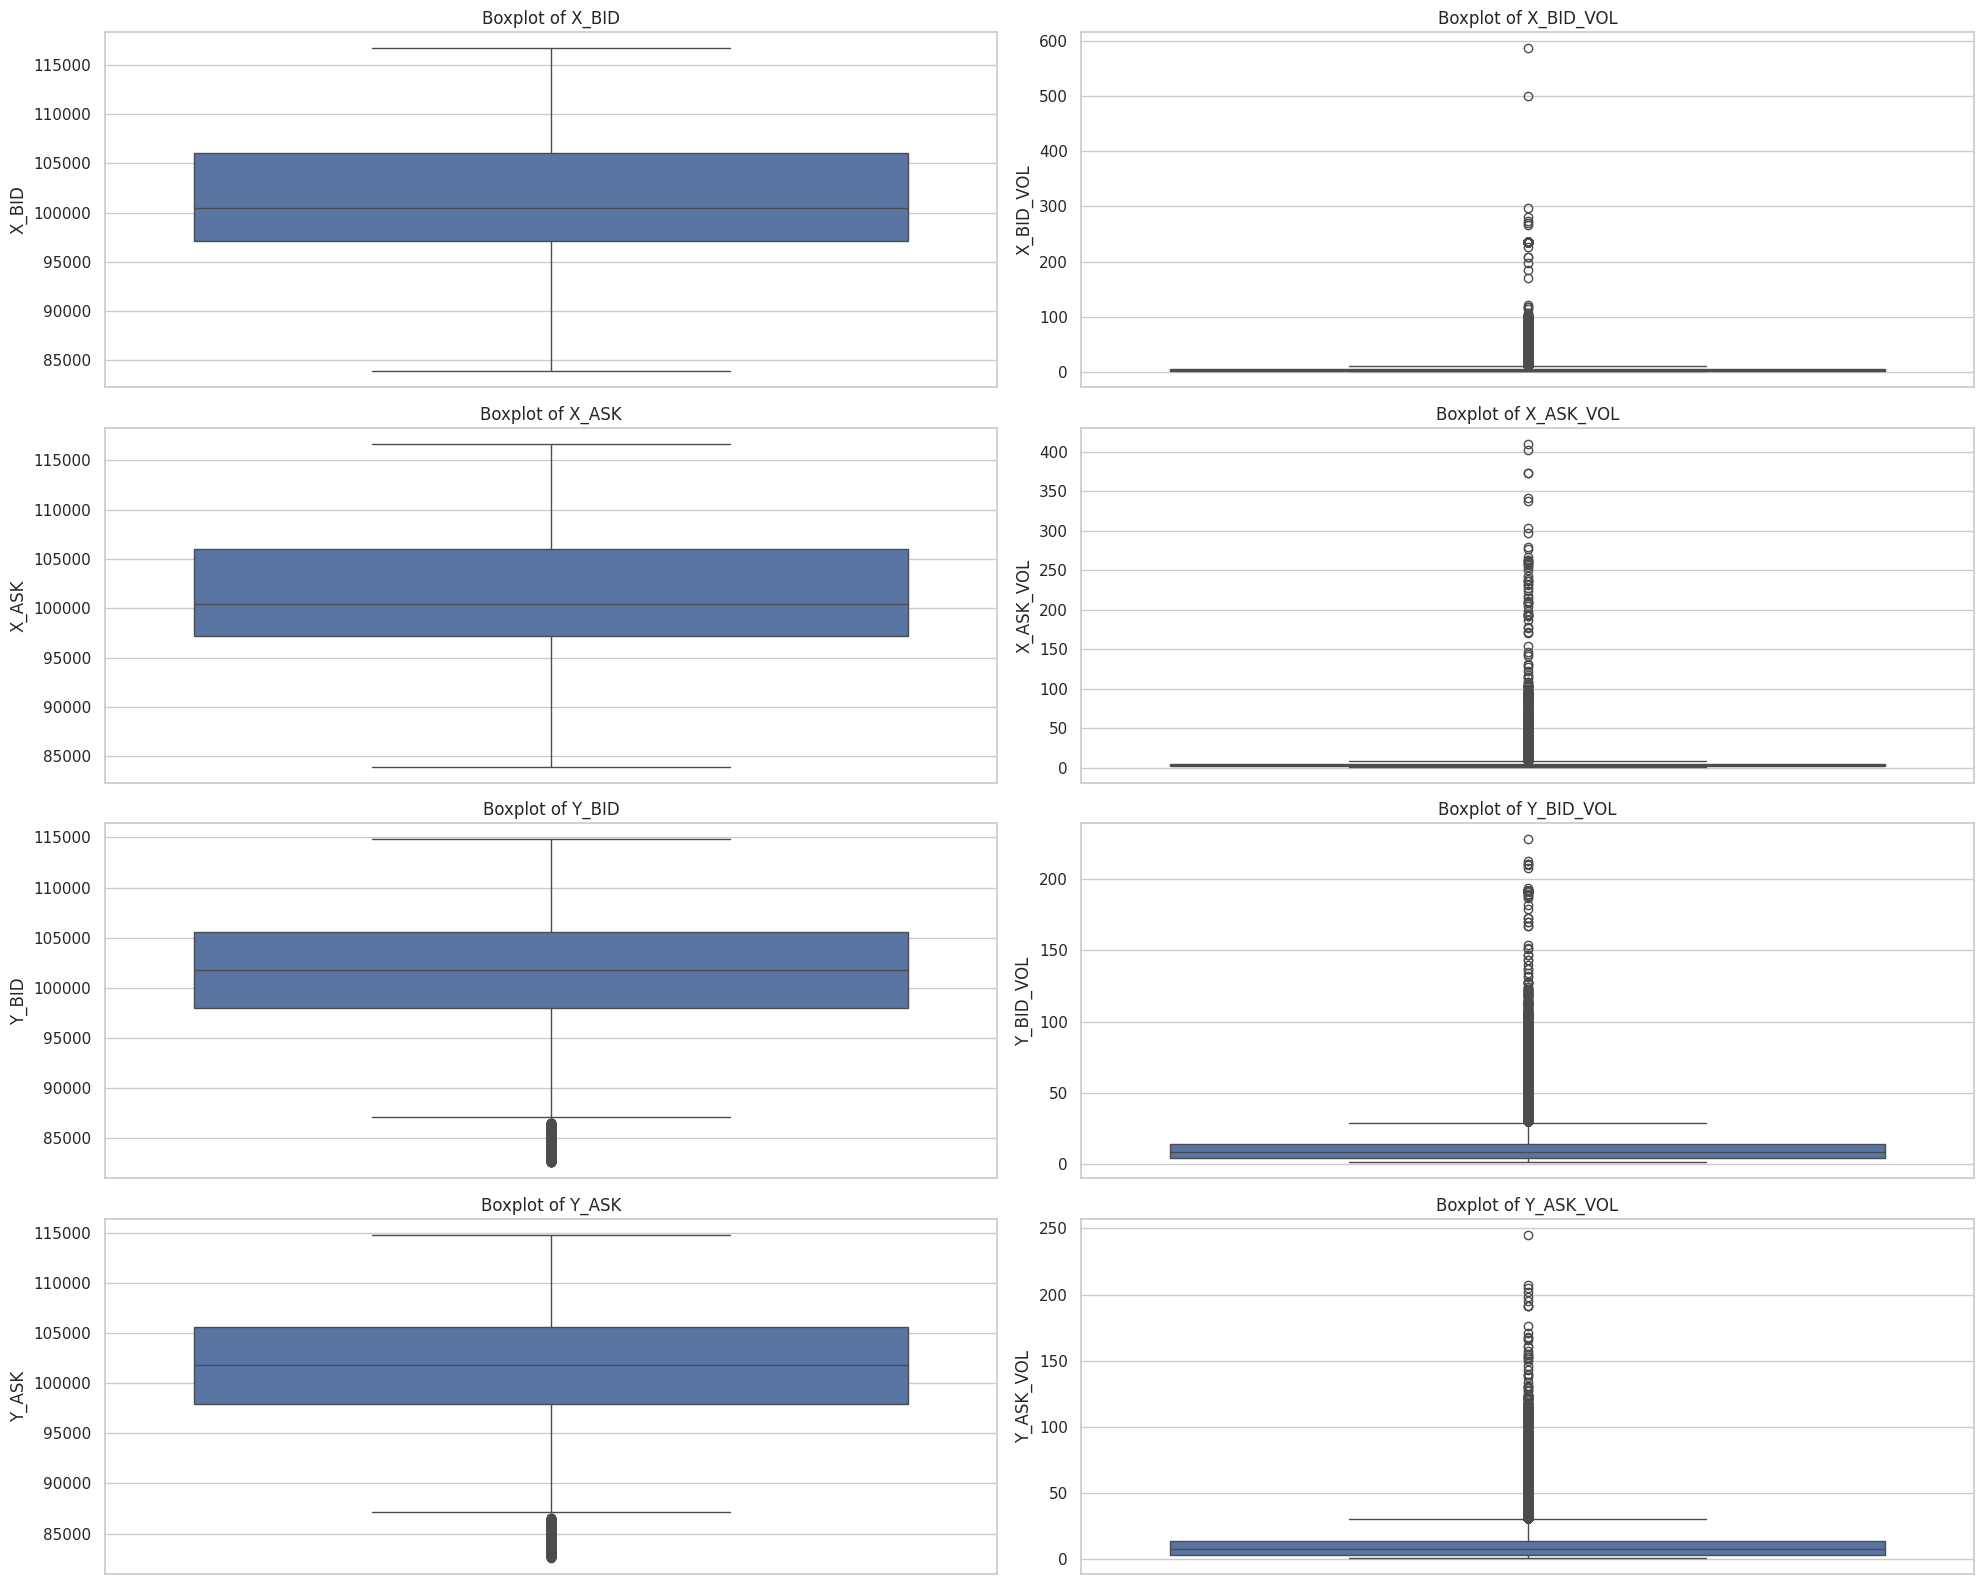

In [20]:
plt.figure(figsize=(20, 16))

for i, col in enumerate(columns):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 16))

for i, col in enumerate(columns):
    plt.subplot(4, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### Insights from Anomaly Detection Visualizations on the entire dataset

These additional visualizations provide deeper insights into the distribution and potential anomalies in the bid and ask prices and volumes for both X and Y. Here's a detailed interpretation of each visualization.

#### Distribution Plots

- **Distribution Plots for Prices (`X_BID`, `X_ASK`, `Y_BID`, `Y_ASK`)**:
  - **Observation**: The distribution plots for the prices show multiple peaks, indicating clusters around certain price levels. These peaks suggest periods of high trading activity or significant market events.
  - **Insight**: The presence of multiple peaks in the price distributions suggests that the data is not normally distributed and may contain periods of increased volatility. This could be due to market events or other external factors.

- **Distribution Plots for Volumes (`X_BID_VOL`, `X_ASK_VOL`, `Y_BID_VOL`, `Y_ASK_VOL`)**:
  - **Observation**: The volume distributions are heavily right-skewed with a long tail. Most of the volume data points are concentrated at the lower end, with a few very high values.
  - **Insight**: The skewness in the volume distributions indicates that there are occasional spikes in trading volume, which could be due to large trades or market anomalies. These spikes could be potential outliers worth investigating further.

#### Boxplots

- **Boxplots for Prices (`X_BID`, `X_ASK`, `Y_BID`, `Y_ASK`)**:
  - **Observation**: The boxplots for the prices show that most of the data points fall within a relatively narrow range, with some outliers present.
  - **Insight**: The outliers in the price data suggest occasional deviations from the typical trading range, which could be due to market shocks or irregular trading activity. Identifying these outliers can help in understanding abnormal market behavior.

- **Boxplots for Volumes (`X_BID_VOL`, `X_ASK_VOL`, `Y_BID_VOL`, `Y_ASK_VOL`)**:
  - **Observation**: The boxplots for the volumes show a large number of outliers, with most of the data points concentrated near the lower end.
  - **Insight**: The high number of outliers in the volume data indicates frequent spikes in trading volume. These spikes could be due to large trades or abnormal trading activity. Detecting these outliers is crucial for understanding market liquidity and potential manipulation.

#### Summary of Insights

The insights gained from these visualizations reveal several key characteristics of the bid and ask prices and volumes:

- **Multiple Peaks in Price Distributions**: Suggest periods of high trading activity or market events.
- **Skewed Volume Distributions**: Indicate occasional spikes in trading volume, which could be outliers.
- **Outliers in Prices and Volumes**: Point to abnormal market behavior or significant events.

The detection of these anomalies highlights the presence of significant market events and periods of increased volatility. These insights suggest that while the current methods are effective in identifying anomalies, they may not fully capture the underlying dynamics of the data. This is where I **thought Kalman filtering could play a crucial role**:

- **Dynamic Filtering**: The Kalman filter is designed to handle time series data by dynamically updating estimates as new data becomes available. This makes it ideal for tracking and smoothing price and volume changes in real-time.
- **Noise Reduction**: The Kalman filter excels at reducing noise and providing a smoothed estimate of the underlying state, which is beneficial in noisy financial data where distinguishing between actual market signals and random fluctuations is essential.
- **Handling Non-Stationary Data**: Financial time series often exhibit non-stationary behavior. The Kalman filter can adapt to these changes, providing more accurate and stable estimates over time.

The detected anomalies using Z-score, IQR, and Isolation Forest methods provide valuable insights into significant market events and periods of increased volatility. However, to capture the underlying dynamics more effectively and provide real-time, noise-reduced estimates, employing a Kalman filter would be highly advantageous. The Kalman filter’s strengths in dynamic filtering, noise reduction, and handling non-stationary data make it a powerful tool for further analysis and trading strategy development in financial markets.

### Statistics of the Cointegrated Target Series

This section provides a comprehensive visualization of the cointegrated target series, Y_BID and X_ASK. These visualizations help in understanding the relationship, distribution, and dynamics between the two series.

This part will have some visualizations we will have repeated before just to recontextualise.

<Figure size 1000x600 with 0 Axes>

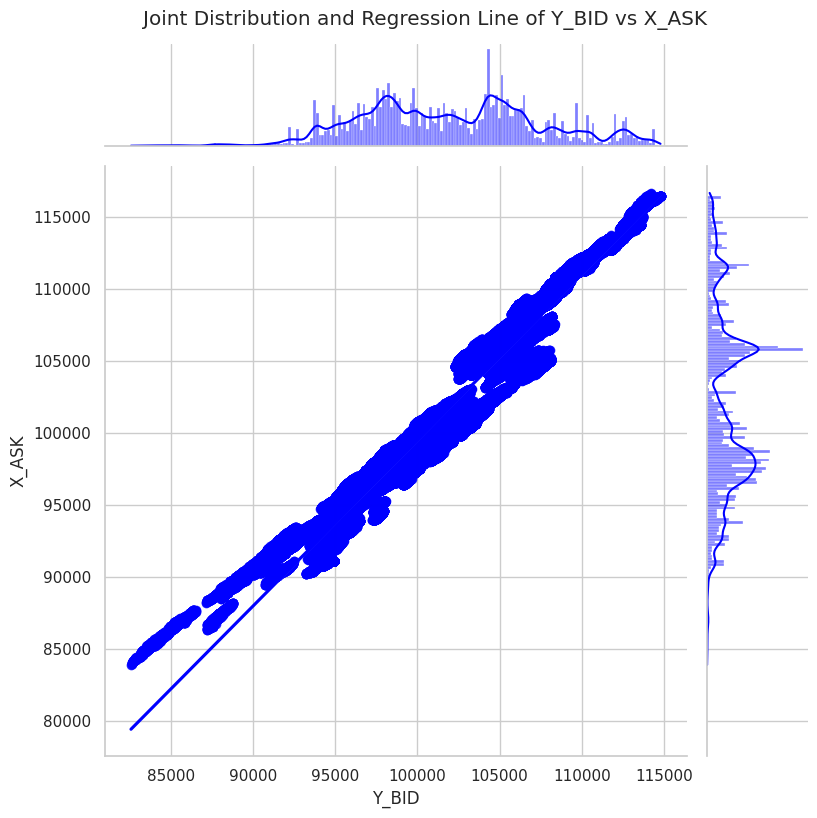

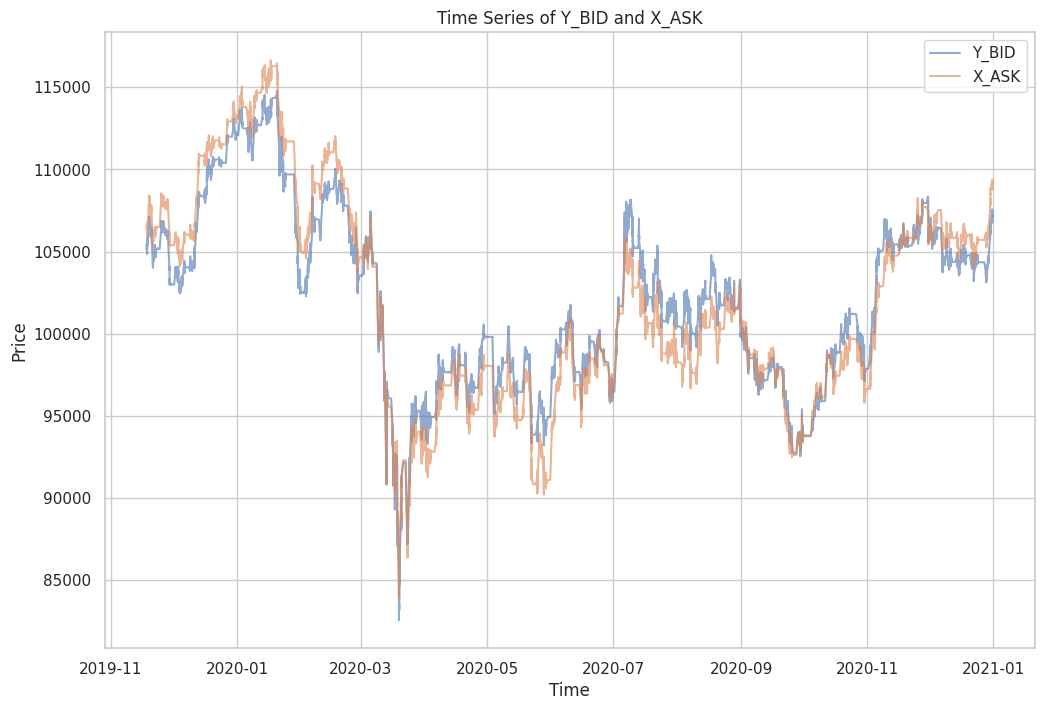

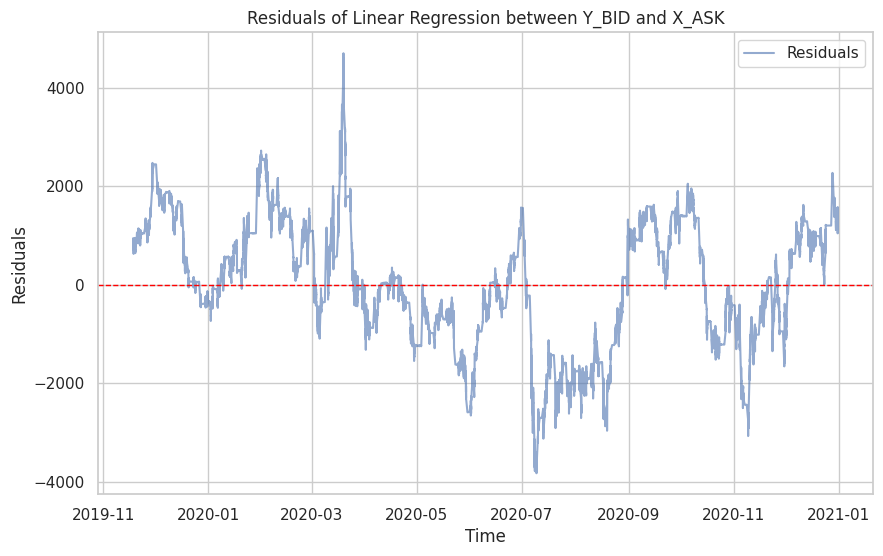

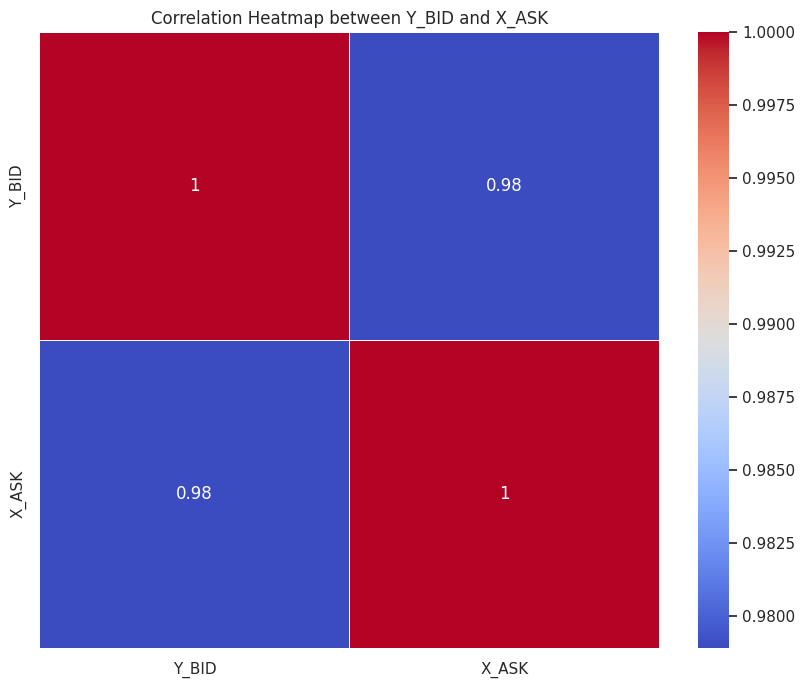

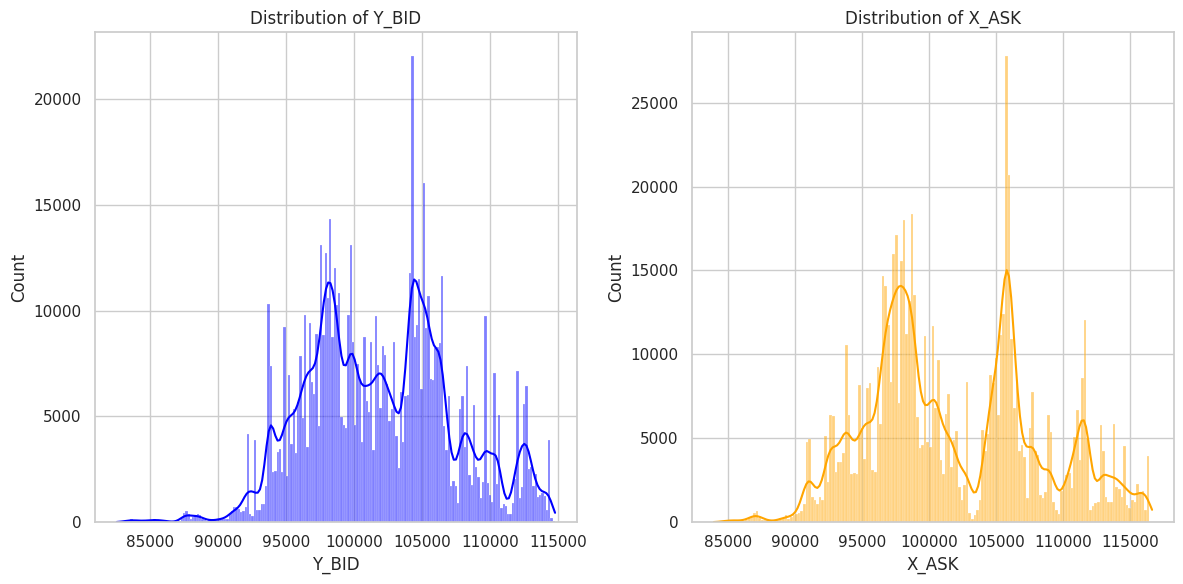

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set plot style
sns.set_theme(style="whitegrid")

# 1. Joint Distribution Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.jointplot(x='Y_BID', y='X_ASK', data=df, kind='reg', color='blue', height=8)
plt.suptitle('Joint Distribution and Regression Line of Y_BID vs X_ASK', y=1.02)
plt.xlabel('Y_BID')
plt.ylabel('X_ASK')
plt.show()

# 2. Time Series Plot of Y_BID and X_ASK
plt.figure(figsize=(12, 8))
plt.plot(df['Y_BID'], label='Y_BID', alpha=0.6)
plt.plot(df['X_ASK'], label='X_ASK', alpha=0.6)
plt.title('Time Series of Y_BID and X_ASK')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 3. Residuals Plot of Linear Regression between Y_BID and X_ASK
# Reshape data for linear regression
X = df['Y_BID'].values.reshape(-1, 1)
y = df['X_ASK'].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Calculate residuals
df['residuals'] = y - model.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(df['residuals'], label='Residuals', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals of Linear Regression between Y_BID and X_ASK')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 4. Correlation Heatmap between Y_BID and X_ASK
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Y_BID', 'X_ASK']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap between Y_BID and X_ASK')
plt.show()

# 5. Distribution Plots of Y_BID and X_ASK
plt.figure(figsize=(12, 6))

# Distribution of Y_BID
plt.subplot(1, 2, 1)
sns.histplot(df['Y_BID'], kde=True, color='blue')
plt.title('Distribution of Y_BID')

# Distribution of X_ASK
plt.subplot(1, 2, 2)
sns.histplot(df['X_ASK'], kde=True, color='orange')
plt.title('Distribution of X_ASK')

plt.tight_layout()
plt.show()

### Interesting: A Strong Linear Relationship between X_ASK and Y_BID

The strong linear relationship between `Y_BID` and `X_ASK`, as evidenced by the scatter plot, joint distribution plot, time series plot, residuals plot, correlation heatmap, and distribution plots, supports the use of linear dynamic models for further analysis. This strengthens our confidence in Kalman filtering as a strong candidate method.

### Anomalies in the Cointegrated series: Need to Clean?

By analyzing anomalies in both X_ASK and Y_BID data, we aim to understand the underlying market dynamics and improve our trading strategies. This comprehensive analysis will help us determine the significance of the detected anomalies and provide insights into their impact on market behavior.

We will employ statistical tests to evaluate whether the detected anomalies are statistically significant compared to normal market conditions. This will inform our decision-making process and potentially highlight periods of increased risk or opportunity.

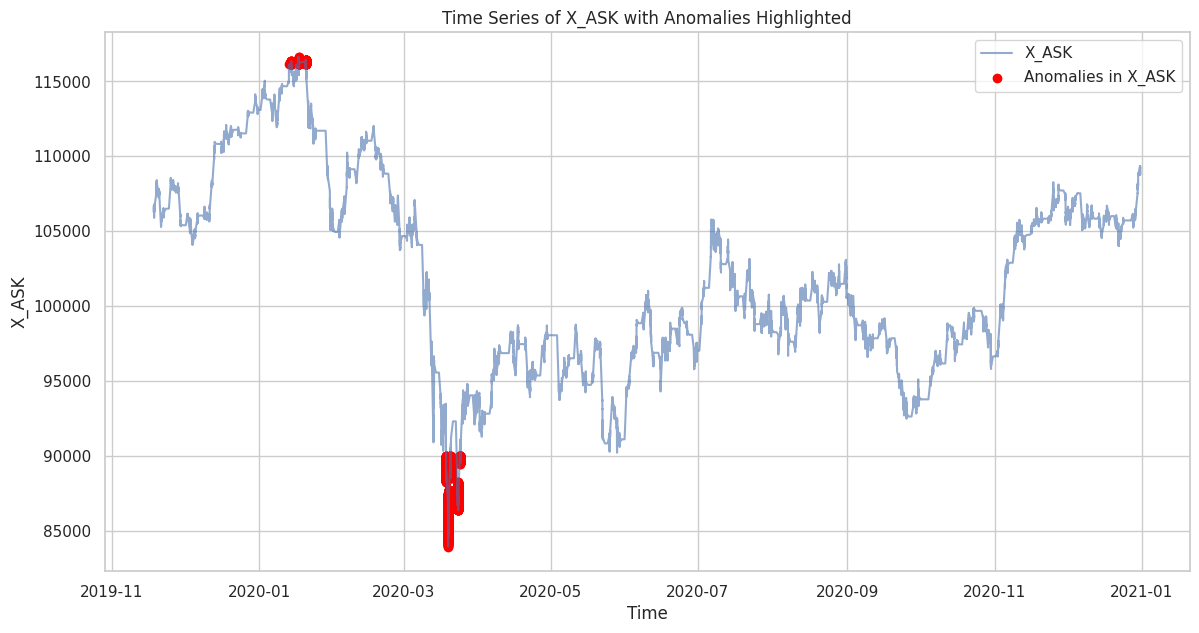

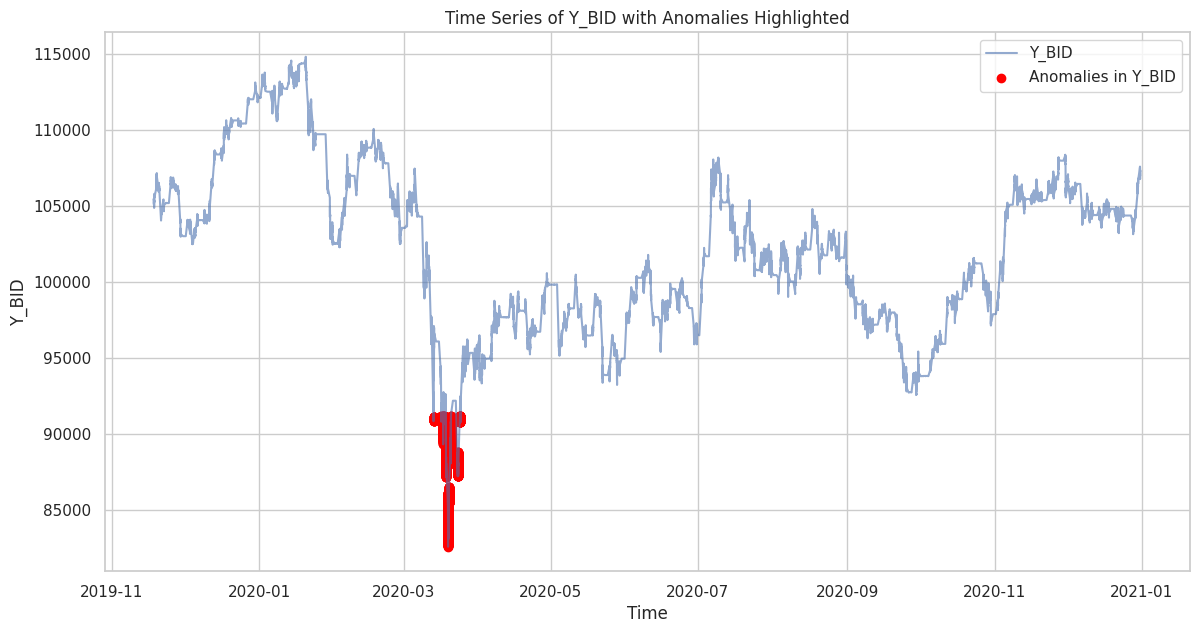

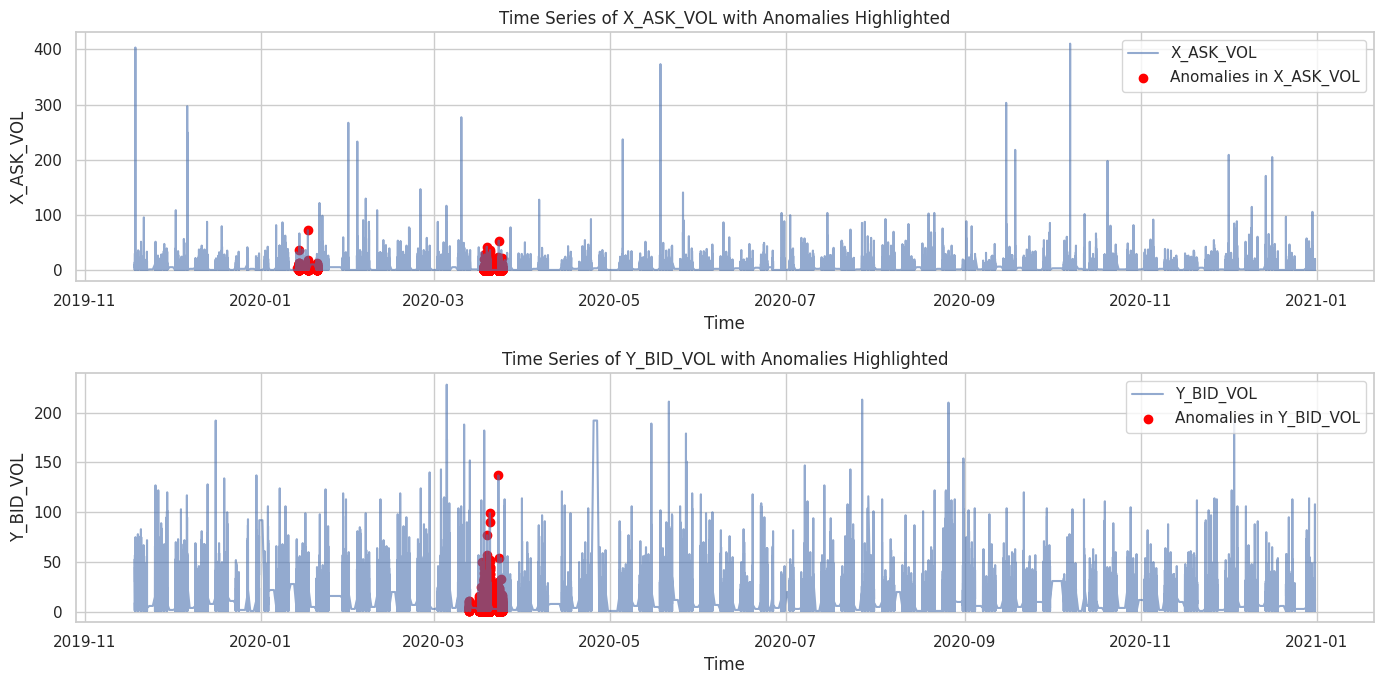

T-test for X_ASK_VOL during anomalies vs. normal period: t-statistic=-44.201579241781886, p-value=0.0
T-test for Y_BID_VOL during anomalies vs. normal period: t-statistic=-125.43183106426322, p-value=0.0
T-test for X_ASK during anomalies vs. normal period: t-statistic=-189.74778005990385, p-value=0.0
T-test for Y_BID during anomalies vs. normal period: t-statistic=-677.4227914928324, p-value=0.0
The anomalies in X_ASK_VOL are statistically significant.
The anomalies in Y_BID_VOL are statistically significant.
The anomalies in X_ASK are statistically significant.
The anomalies in Y_BID are statistically significant.


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.ensemble import IsolationForest

# Load data
df = pd.read_csv('data/final_data_10s.csv')

# Convert 'Time' column to datetime and set as index
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df.dropna(subset=['Time'], inplace=True)
df.set_index('Time', inplace=True)

# Detect anomalies using Z-score, IQR, and Isolation Forest methods

# Z-score method
for col in ['X_ASK', 'Y_BID']:
    df[f'{col}_Z'] = (df[col] - df[col].mean()) / df[col].std()
    df[f'{col}_ANOMALY_Z'] = df[f'{col}_Z'].abs() > 3

# IQR method
for col in ['X_ASK', 'Y_BID']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[f'{col}_ANOMALY_IQR'] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))

# Isolation Forest method
iso_forest = IsolationForest(contamination=0.01, random_state=42)
for col in ['X_ASK', 'Y_BID']:
    df[f'{col}_ANOMALY_ISO'] = iso_forest.fit_predict(df[[col]])
    df[f'{col}_ANOMALY_ISO'] = df[f'{col}_ANOMALY_ISO'] == -1

# Combine anomalies detected by any method
for col in ['X_ASK', 'Y_BID']:
    df[f'{col}_ANOMALY'] = df[[f'{col}_ANOMALY_Z', f'{col}_ANOMALY_IQR', f'{col}_ANOMALY_ISO']].any(axis=1)

# Extract anomalies
anomalies_X_ASK = df[df['X_ASK_ANOMALY']]
anomalies_Y_BID = df[df['Y_BID_ANOMALY']]

anomaly_times_X_ASK = anomalies_X_ASK.index
anomaly_times_Y_BID = anomalies_Y_BID.index

# 1. Plot X_ASK and Y_BID with anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(df['X_ASK'], label='X_ASK', alpha=0.6)
plt.scatter(anomaly_times_X_ASK, df.loc[anomaly_times_X_ASK]['X_ASK'], color='red', label='Anomalies in X_ASK')
plt.title('Time Series of X_ASK with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('X_ASK')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df['Y_BID'], label='Y_BID', alpha=0.6)
plt.scatter(anomaly_times_Y_BID, df.loc[anomaly_times_Y_BID]['Y_BID'], color='red', label='Anomalies in Y_BID')
plt.title('Time Series of Y_BID with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Y_BID')
plt.legend()
plt.show()

# 2. Extract volumes during anomalies
anomaly_volumes_X_ASK = df.loc[anomaly_times_X_ASK, ['X_ASK_VOL', 'Y_BID_VOL']]
anomaly_volumes_Y_BID = df.loc[anomaly_times_Y_BID, ['Y_BID_VOL', 'X_ASK_VOL']]

# 3. Plot volumes during anomalies
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df['X_ASK_VOL'], label='X_ASK_VOL', alpha=0.6)
plt.scatter(anomaly_times_X_ASK, df.loc[anomaly_times_X_ASK]['X_ASK_VOL'], color='red', label='Anomalies in X_ASK_VOL')
plt.title('Time Series of X_ASK_VOL with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('X_ASK_VOL')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Y_BID_VOL'], label='Y_BID_VOL', alpha=0.6)
plt.scatter(anomaly_times_Y_BID, df.loc[anomaly_times_Y_BID]['Y_BID_VOL'], color='red', label='Anomalies in Y_BID_VOL')
plt.title('Time Series of Y_BID_VOL with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Y_BID_VOL')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Statistical Analysis to Test Significance of Anomalies

# Define the normal period for comparison
normal_period_start = '2019-11-18'
normal_period_end = '2019-12-31'

normal_period = df.loc[normal_period_start:normal_period_end]

# Conduct t-tests for volumes during anomalies vs. normal periods
t_stat_X_ASK_VOL, p_value_X_ASK_VOL = ttest_ind(anomaly_volumes_X_ASK['X_ASK_VOL'], normal_period['X_ASK_VOL'], equal_var=False)
t_stat_Y_BID_VOL, p_value_Y_BID_VOL = ttest_ind(anomaly_volumes_Y_BID['Y_BID_VOL'], normal_period['Y_BID_VOL'], equal_var=False)

# Conduct t-tests for prices during anomalies vs. normal periods
t_stat_X_ASK, p_value_X_ASK = ttest_ind(anomalies_X_ASK['X_ASK'], normal_period['X_ASK'], equal_var=False)
t_stat_Y_BID, p_value_Y_BID = ttest_ind(anomalies_Y_BID['Y_BID'], normal_period['Y_BID'], equal_var=False)

# Print statistical test results
print(f"T-test for X_ASK_VOL during anomalies vs. normal period: t-statistic={t_stat_X_ASK_VOL}, p-value={p_value_X_ASK_VOL}")
print(f"T-test for Y_BID_VOL during anomalies vs. normal period: t-statistic={t_stat_Y_BID_VOL}, p-value={p_value_Y_BID_VOL}")

print(f"T-test for X_ASK during anomalies vs. normal period: t-statistic={t_stat_X_ASK}, p-value={p_value_X_ASK}")
print(f"T-test for Y_BID during anomalies vs. normal period: t-statistic={t_stat_Y_BID}, p-value={p_value_Y_BID}")

# 5. Decision Making Based on Statistical Tests

if p_value_X_ASK_VOL < 0.05:
    print("The anomalies in X_ASK_VOL are statistically significant.")
else:
    print("The anomalies in X_ASK_VOL are not statistically significant.")

if p_value_Y_BID_VOL < 0.05:
    print("The anomalies in Y_BID_VOL are statistically significant.")
else:
    print("The anomalies in Y_BID_VOL are not statistically significant.")

if p_value_X_ASK < 0.05:
    print("The anomalies in X_ASK are statistically significant.")
else:
    print("The anomalies in X_ASK are not statistically significant.")

if p_value_Y_BID < 0.05:
    print("The anomalies in Y_BID are statistically significant.")
else:
    print("The anomalies in Y_BID are not statistically significant.")

Interesting, there seems to have been a buying spree of Y and a selling of X stocks which seems like someone performed a pairs trading over these instruments which proves that there is a reliable opportunity here to exploit.

### Interpretation of T-Test Results

The results of the t-tests indicate that the anomalies detected in both the prices and volumes for `X_ASK` and `Y_BID` are statistically significant. Here’s a detailed interpretation of these results and their implications:

#### T-Test Results

- **T-test for X_ASK_VOL during anomalies vs. normal period**:
  - **t-statistic**: -44.201579241781886
  - **p-value**: 0.0
  - **Interpretation**: The p-value is 0.0, which is less than 0.05, indicating that the anomalies in `X_ASK_VOL` are statistically significant. This suggests that the volume spikes observed during the anomalies are not random and represent meaningful deviations from normal trading activity.

- **T-test for Y_BID_VOL during anomalies vs. normal period**:
  - **t-statistic**: -125.43183106426322
  - **p-value**: 0.0
  - **Interpretation**: The p-value is 0.0, indicating that the anomalies in `Y_BID_VOL` are statistically significant. This implies that the volume spikes during the anomalies are significant and likely driven by specific market events or actions.

- **T-test for X_ASK during anomalies vs. normal period**:
  - **t-statistic**: -189.74778005990385
  - **p-value**: 0.0
  - **Interpretation**: The p-value is 0.0, indicating that the anomalies in `X_ASK` are statistically significant. This means the price changes observed during the anomalies are not random and represent significant deviations from the normal price range.

- **T-test for Y_BID during anomalies vs. normal period**:
  - **t-statistic**: -677.4227914928324
  - **p-value**: 0.0
  - **Interpretation**: The p-value is 0.0, indicating that the anomalies in `Y_BID` are statistically significant. This suggests that the price changes during the anomalies are meaningful and likely caused by specific factors or events in the market.

### Why T-Tests are a Good Measure

T-tests are a robust statistical tool for comparing the means of two groups. They help determine whether the differences observed are statistically significant or due to random chance. This makes them ideal for analyzing anomalies in financial data, as they provide a clear indication of whether detected anomalies represent meaningful deviations from normal market behavior.

### Implications

The statistically significant anomalies in `X_ASK` and `Y_BID` prices and volumes suggest:

1. **Market Events and Actions**:
   - Significant anomalies likely result from specific market events, such as large trades, news, or economic factors.

2. **Informed Trading Decisions**:
   - Recognizing non-random anomalies allows traders to adjust strategies to leverage or mitigate their impact.

3. **Risk Management**:
   - Identifying significant anomalies helps implement strategies to protect against unexpected market movements, reducing potential losses.

4. **Improving Trading Models**:
   - Incorporating significant anomalies into models enhances their predictive power and robustness, improving performance under various conditions.

By identifying and understanding these anomalies, traders can make better decisions, optimize strategies, and manage risk more effectively. The results of the t-tests clearly show that the anomalies in `X_ASK` and `Y_BID` prices and volumes are statistically significant. This indicates that the deviations observed during these periods are meaningful and likely driven by specific market events or actions. By recognizing and understanding these anomalies, traders can improve their trading strategies, make more informed decisions, and better manage risk in the market.

### Are our target assets stable over time?

Visualizing the spread between X_ASK and Y_BID along with its rolling mean and standard deviation bands is crucial for understanding the dynamics of the relationship between these two variables. The spread can highlight periods of divergence and convergence, which are essential for identifying trading opportunities and potential risks. By plotting the spread with its rolling mean and standard deviation bands, we can assess the stability and volatility of the spread over time.

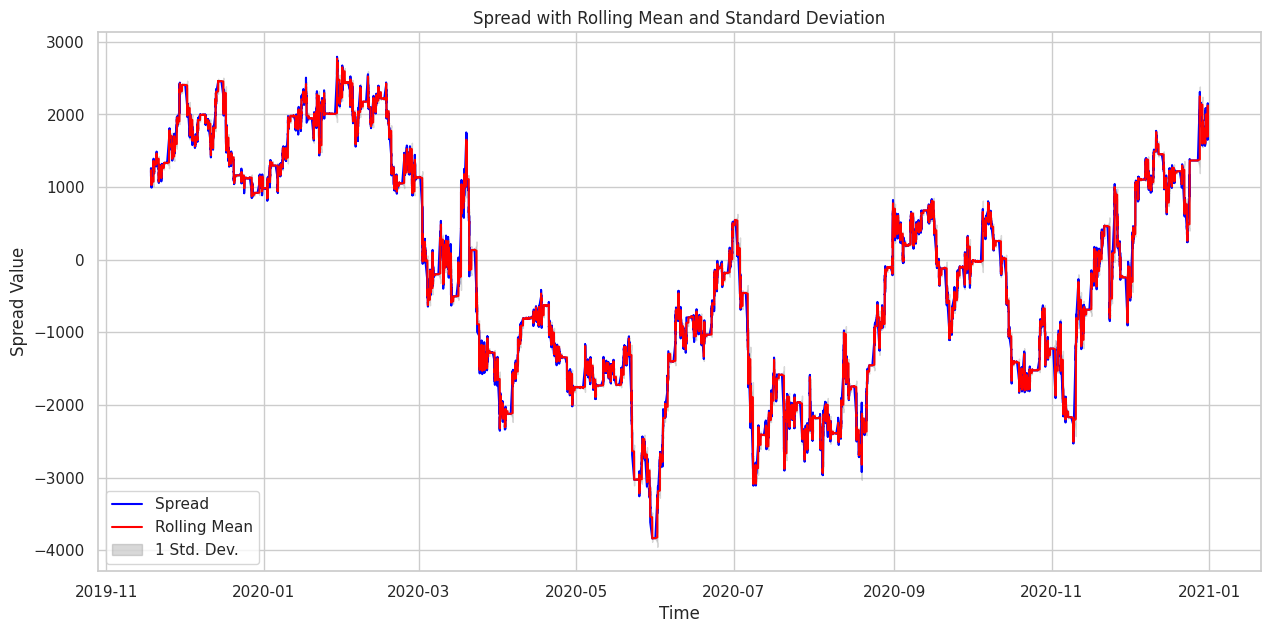

In [29]:
# Calculate the spread, rolling mean, and rolling standard deviation
df['Spread'] = df['X_ASK'] - df['Y_BID']
df['Rolling_Mean'] = df['Spread'].rolling(window=50).mean()
df['Rolling_Std'] = df['Spread'].rolling(window=50).std()

# Plot the spread with its rolling mean and standard deviation bands
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Spread'], label='Spread', color='blue')
plt.plot(df.index, df['Rolling_Mean'], label='Rolling Mean', color='red')
plt.fill_between(df.index, df['Rolling_Mean'] - df['Rolling_Std'], df['Rolling_Mean'] + df['Rolling_Std'], color='gray', alpha=0.3, label='1 Std. Dev.')
plt.title('Spread with Rolling Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Spread Value')
plt.legend()
plt.show()


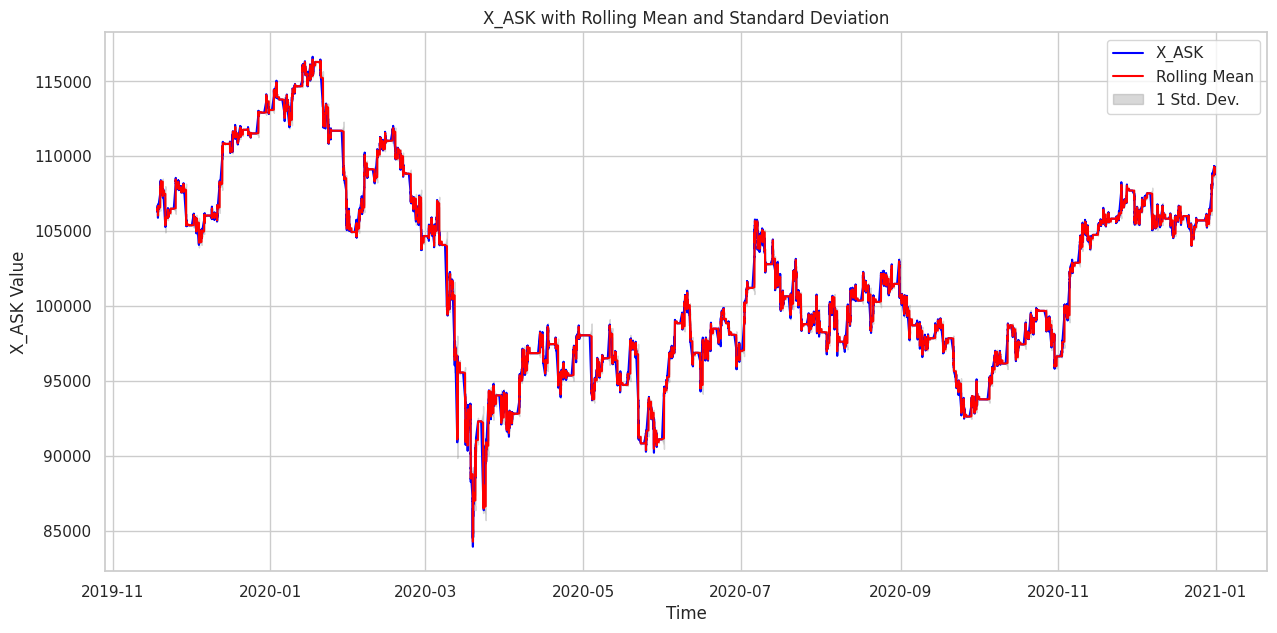

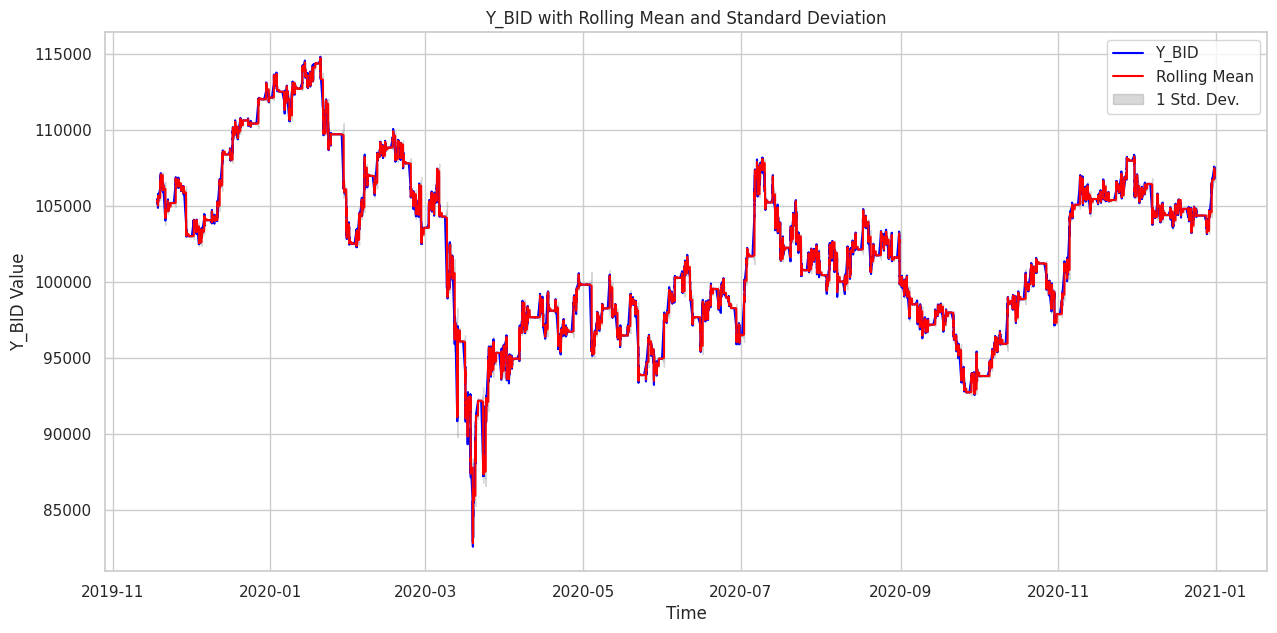

In [30]:
# Calculate rolling mean and standard deviation for X_ASK and Y_BID
df['X_ASK_Rolling_Mean'] = df['X_ASK'].rolling(window=50).mean()
df['X_ASK_Rolling_Std'] = df['X_ASK'].rolling(window=50).std()
df['Y_BID_Rolling_Mean'] = df['Y_BID'].rolling(window=50).mean()
df['Y_BID_Rolling_Std'] = df['Y_BID'].rolling(window=50).std()

# Plot X_ASK with rolling mean and standard deviation bands
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['X_ASK'], label='X_ASK', color='blue')
plt.plot(df.index, df['X_ASK_Rolling_Mean'], label='Rolling Mean', color='red')
plt.fill_between(df.index, df['X_ASK_Rolling_Mean'] - df['X_ASK_Rolling_Std'], df['X_ASK_Rolling_Mean'] + df['X_ASK_Rolling_Std'], color='gray', alpha=0.3, label='1 Std. Dev.')
plt.title('X_ASK with Rolling Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('X_ASK Value')
plt.legend()
plt.show()

# Plot Y_BID with rolling mean and standard deviation bands
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Y_BID'], label='Y_BID', color='blue')
plt.plot(df.index, df['Y_BID_Rolling_Mean'], label='Rolling Mean', color='red')
plt.fill_between(df.index, df['Y_BID_Rolling_Mean'] - df['Y_BID_Rolling_Std'], df['Y_BID_Rolling_Mean'] + df['Y_BID_Rolling_Std'], color='gray', alpha=0.3, label='1 Std. Dev.')
plt.title('Y_BID with Rolling Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Y_BID Value')
plt.legend()
plt.show()


### Insights from Rolling Mean and Standard Deviation Analysis

The provided visualizations show the spread between `X_ASK` and `Y_BID` along with their individual price series, including their rolling mean and standard deviation. Here are the key insights:

#### Spread Analysis

Spread with Rolling Mean and Standard Deviation

- **Trend Identification**:
  - The spread exhibits significant fluctuations over time, indicating periods of divergence and convergence between `X_ASK` and `Y_BID`.
  - The spread tends to revert to its rolling mean, suggesting mean-reverting behavior which can be exploited for pairs trading strategies.

- **Volatility**:
  - The standard deviation bands highlight periods of high and low volatility in the spread.
  - Notably, periods of high volatility are often followed by corrections, presenting potential trading opportunities.

#### X_ASK Analysis

X_ASK with Rolling Mean and Standard Deviation

- **Price Behavior**:
  - `X_ASK` shows a clear downtrend in early 2020, followed by a recovery and subsequent fluctuations.
  - The rolling mean captures these trends effectively, providing a smoother representation of the price movements.

- **Volatility**:
  - The standard deviation bands around `X_ASK` indicate periods of heightened volatility, particularly during market corrections and recoveries.
  - Understanding these volatility patterns is crucial for risk management and timing trades.

#### Y_BID Analysis

Y_BID with Rolling Mean and Standard Deviation

- **Price Behavior**:
  - `Y_BID` mirrors the behavior of `X_ASK`, showing similar trends and volatility patterns.
  - The rolling mean provides a clear depiction of the overall trend, filtering out short-term noise.

- **Volatility**:
  - Similar to `X_ASK`, the standard deviation bands around `Y_BID` highlight periods of increased volatility.
  - These periods are critical for identifying potential entry and exit points in trading strategies.

### Implications

1. **Trading Opportunities**:
   - The mean-reverting behavior of the spread suggests that there are trading opportunities when the spread deviates significantly from its rolling mean. We can exploit these deviations by entering trades that profit from the expected reversion.

2. **Volatility Management**:
   - Understanding periods of high volatility in `X_ASK` and `Y_BID` helps in managing risk. During high volatility periods, we might adopt more conservative strategies or use hedging techniques to protect against adverse price movements.

3. **Pairs Trading Strategy**:
   - The analysis *supports the use of pairs trading strategies*, where traders take advantage of the mean-reverting nature of the spread between `X_ASK` and `Y_BID`. This strategy involves buying one asset and selling the other when the spread deviates from its mean.

Now that we have identified and analyzed the dataset and know that we can perform pairs trading, the next steps involve refining and developing a pairs trading strategy. Here's a step-by-step outline of what we can do next:

 - Strategy Definition: Define the pairs trading strategy based on the spread.
 - Signal Generation: Create trading signals based on the spread.
 - Backtesting: Backtest the strategy using historical data.
 - Performance Metrics: Evaluate the performance of the strategy.

### Step 1: Simple Strategy

In this section, we define a naive pairs trading strategy using the spread between `Y_BID` and `X_ASK`. This strategy leverages the mean-reverting nature of the spread to identify trading opportunities.

#### Trading Rules

- **Entry**: Initiate trades when the spread deviates significantly from its mean.

  - **Long Position**: Enter a long position if the spread is significantly below the mean.
  - **Short Position**: Enter a short position if the spread is significantly above the mean.
  
- **Exit**: Close the position when the spread reverts to its mean.

This approach assumes that the spread between the two prices will revert to its historical mean over time, allowing traders to profit from these deviations.

This initial step sets up the basic framework for the pairs trading strategy by calculating the necessary metrics (spread, rolling mean, rolling standard deviation, and Z-score) that will be used to identify trading signals based on the mean-reverting nature of the spread.

In [32]:
# Step 1: Simple Strategy

# Function to load and preprocess the data
def load_data(file_path='data/final_data_10s.csv'):
    """
    Load data from a CSV file, parse the 'Time' column to datetime, and set it as the index.

    Parameters:
    file_path (str): The path to the CSV file containing the data.

    Returns:
    pd.DataFrame: The preprocessed data with 'Time' as the index.
    """
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')  # Parse 'Time' column to datetime
    df.dropna(subset=['Time'], inplace=True)  # Drop rows with invalid 'Time' values
    df.set_index('Time', inplace=True)  # Set 'Time' as the index
    print(f"DataFrame loaded with {df.shape[0]} rows and {df.shape[1]} columns.")  # Print the shape of the DataFrame
    return df

# Load the DataFrame
df = load_data()
df.index = pd.to_datetime(df.index)  # Ensure the index is in datetime format

# Display the first few rows of the DataFrame
print(df.head())

# Calculate the spread between Y_BID and X_ASK
df['Spread'] = df['Y_BID'] - df['X_ASK']

# Calculate the rolling mean and standard deviation of the spread
window = 60  # 60-period moving window
df['mean_spread'] = df['Spread'].rolling(window=window).mean()
df['std_spread'] = df['Spread'].rolling(window=window).std()

# Calculate the Z-score of the spread
df['zscore_spread'] = (df['Spread'] - df['mean_spread']) / df['std_spread']

DataFrame loaded with 737739 rows and 8 columns.
                        X_BID  X_BID_VOL     X_ASK  X_ASK_VOL     Y_BID  \
Time                                                                      
2019-11-18 08:00:00  106340.0       15.0  106348.0       11.0  105200.0   
2019-11-18 08:00:10  106312.0        6.0  106320.0        9.0  105180.0   
2019-11-18 08:00:20  106312.0        7.0  106320.0       12.0  105170.0   
2019-11-18 08:00:30  106336.0       22.0  106340.0        1.0  105190.0   
2019-11-18 08:00:40  106352.0        2.0  106356.0        4.0  105200.0   

                     Y_BID_VOL     Y_ASK  Y_ASK_VOL  
Time                                                 
2019-11-18 08:00:00        9.0  105210.0       19.0  
2019-11-18 08:00:10        5.0  105190.0       13.0  
2019-11-18 08:00:20       32.0  105180.0        1.0  
2019-11-18 08:00:30       10.0  105200.0       19.0  
2019-11-18 08:00:40       29.0  105220.0       24.0  


#### Signal Generation

Generate trading signals based on the spread.

In [33]:
# Define thresholds for entering and exiting trades
entry_threshold = 2.0
exit_threshold = 0.5

# Generate trading signals
df['long_signal'] = (df['zscore_spread'] < -entry_threshold).astype(int)
df['short_signal'] = (df['zscore_spread'] > entry_threshold).astype(int)
df['exit_signal'] = (df['zscore_spread'].abs() < exit_threshold).astype(int)

# Combine signals into a single signal column
df['signal'] = 0
df.loc[df['long_signal'] == 1, 'signal'] = 1
df.loc[df['short_signal'] == 1, 'signal'] = -1
df.loc[df['exit_signal'] == 1, 'signal'] = 0

# Forward fill positions
df['positions'] = df['signal'].replace(0, np.nan).ffill().fillna(0)

df[['Spread', 'mean_spread', 'std_spread', 'zscore_spread', 'signal', 'positions']].tail()

Spread  mean_spread  std_spread  zscore_spread  signal  \
Time                                                                          
2020-12-31 09:59:20 -1954.0 -1948.500000   33.260400      -0.165362       0   
2020-12-31 09:59:30 -1998.0 -1948.500000   33.260400      -1.488256       0   
2020-12-31 09:59:40 -1974.0 -1948.133333   32.846570      -0.787500       0   
2020-12-31 09:59:50 -1924.0 -1946.766667   32.095391       0.709344       0   
2020-12-31 10:00:00 -1924.0 -1945.800000   31.889002       0.683621       0   

                     positions  
Time                            
2020-12-31 09:59:20       -1.0  
2020-12-31 09:59:30       -1.0  
2020-12-31 09:59:40       -1.0  
2020-12-31 09:59:50       -1.0  
2020-12-31 10:00:00       -1.0

#### Visualizing the trading signals

The data frequency is very high so might not capture everything at a very high resolution

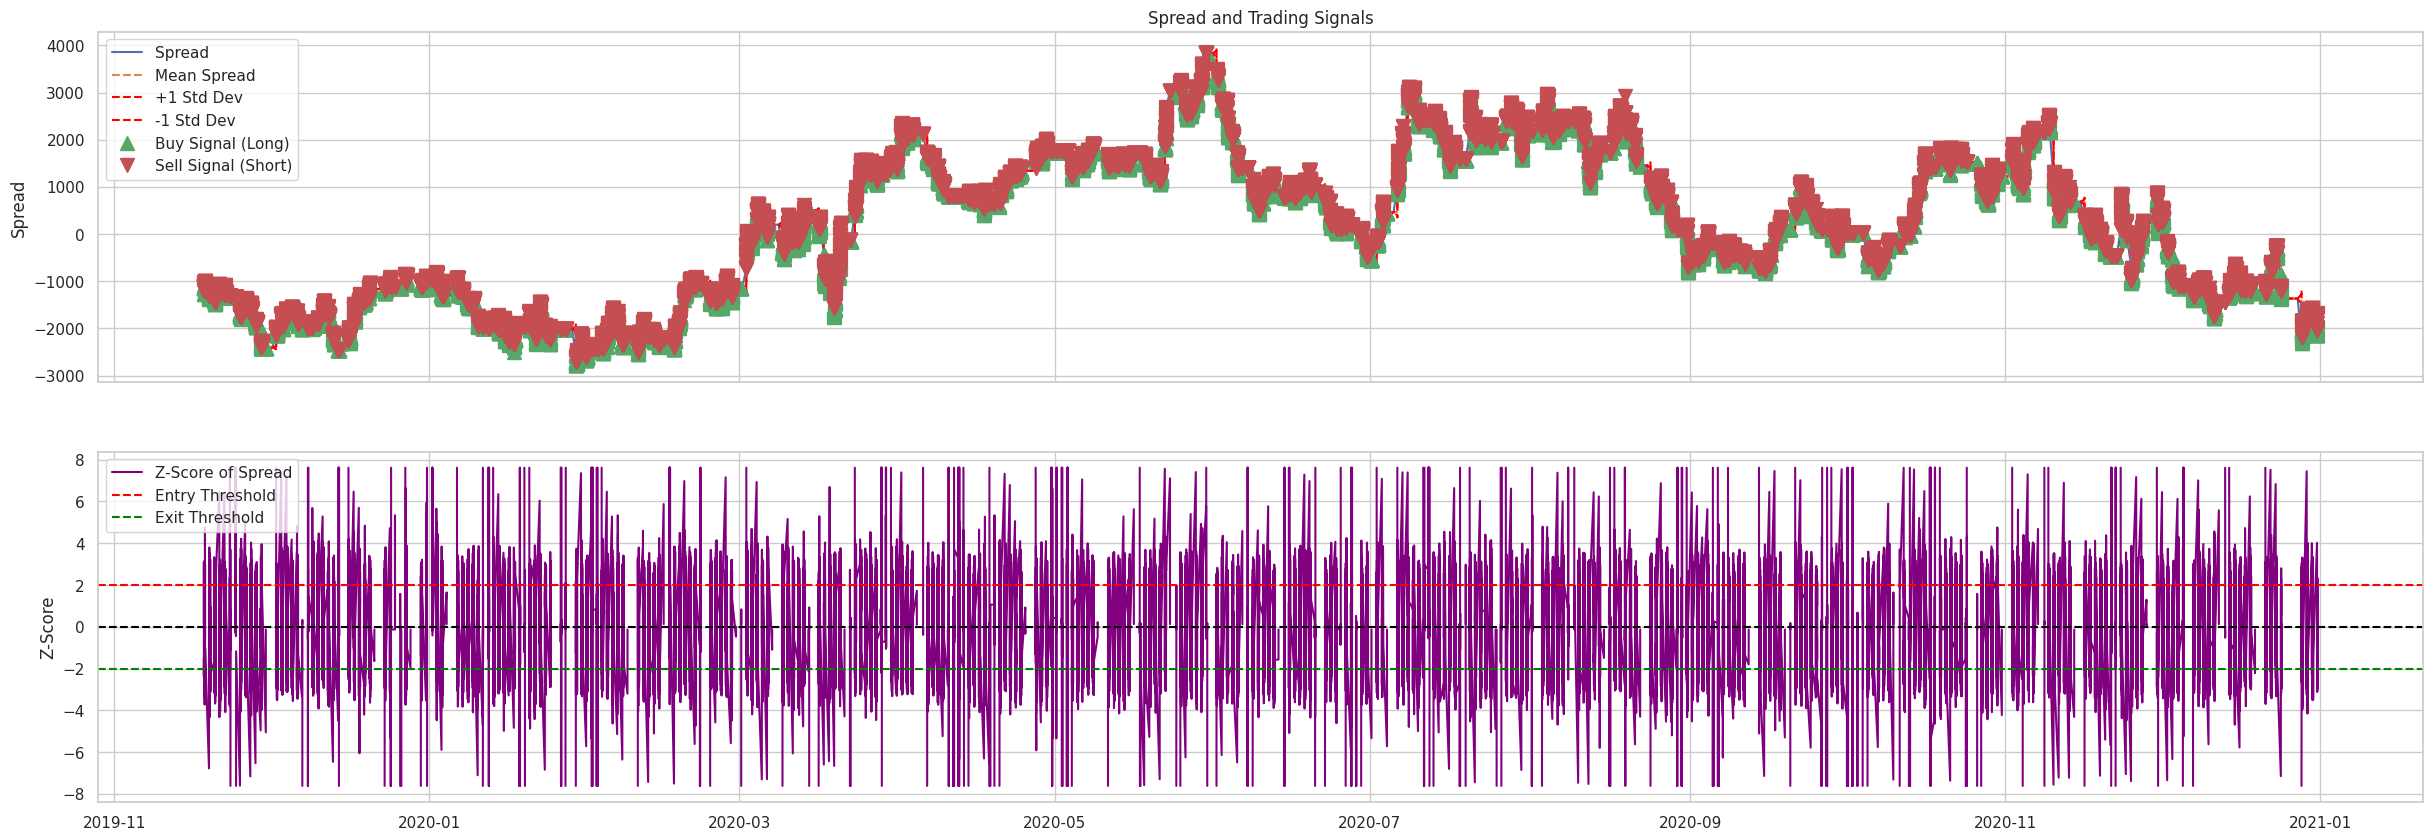

In [48]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

# Plot the spread, mean spread, and standard deviations on the first subplot
ax1.plot(df.index, df['Spread'], label='Spread')
ax1.plot(df.index, df['mean_spread'], label='Mean Spread', linestyle='--')
ax1.plot(df.index, df['mean_spread'] + df['std_spread'], label='+1 Std Dev', linestyle='--', color='red')
ax1.plot(df.index, df['mean_spread'] - df['std_spread'], label='-1 Std Dev', linestyle='--', color='red')
ax1.set_ylabel('Spread')
ax1.legend()
ax1.set_title('Spread and Trading Signals')

# Highlight buy (long) and sell (short) signals
ax1.plot(df.index[df['long_signal'] == 1], df['Spread'][df['long_signal'] == 1], '^', markersize=10, color='g', label='Buy Signal (Long)')
ax1.plot(df.index[df['short_signal'] == 1], df['Spread'][df['short_signal'] == 1], 'v', markersize=10, color='r', label='Sell Signal (Short)')

# Plot the z-score of the spread on the second subplot
ax2.plot(df.index, df['zscore_spread'], label='Z-Score of Spread', color='purple')
ax2.axhline(entry_threshold, color='red', linestyle='--', label='Entry Threshold')
ax2.axhline(-entry_threshold, color='green', linestyle='--', label='Exit Threshold')
ax2.axhline(0, color='black', linestyle='--')
ax2.set_ylabel('Z-Score')
ax2.legend()

# Adding legends for buy and sell signals
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# Show the plot
plt.show()


#### Backtesting and Evaluation

Backtesting this simple pairs trading strategy allows us to evaluate its performance and understand its profitability. By comparing the cumulative returns of the strategy with the market, we can assess whether the strategy outperforms a passive investment. Plotting the portfolio value over time provides a clear visual representation of the strategy's performance and its ability to grow the initial capital. This analysis is crucial for refining the strategy and making informed trading decisions.

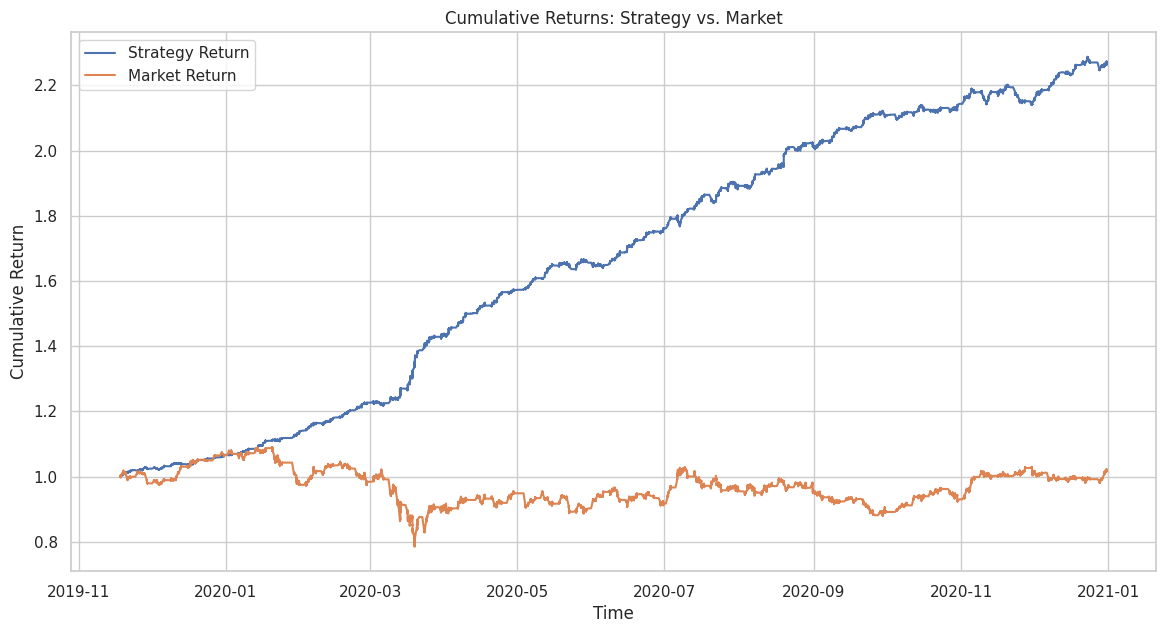

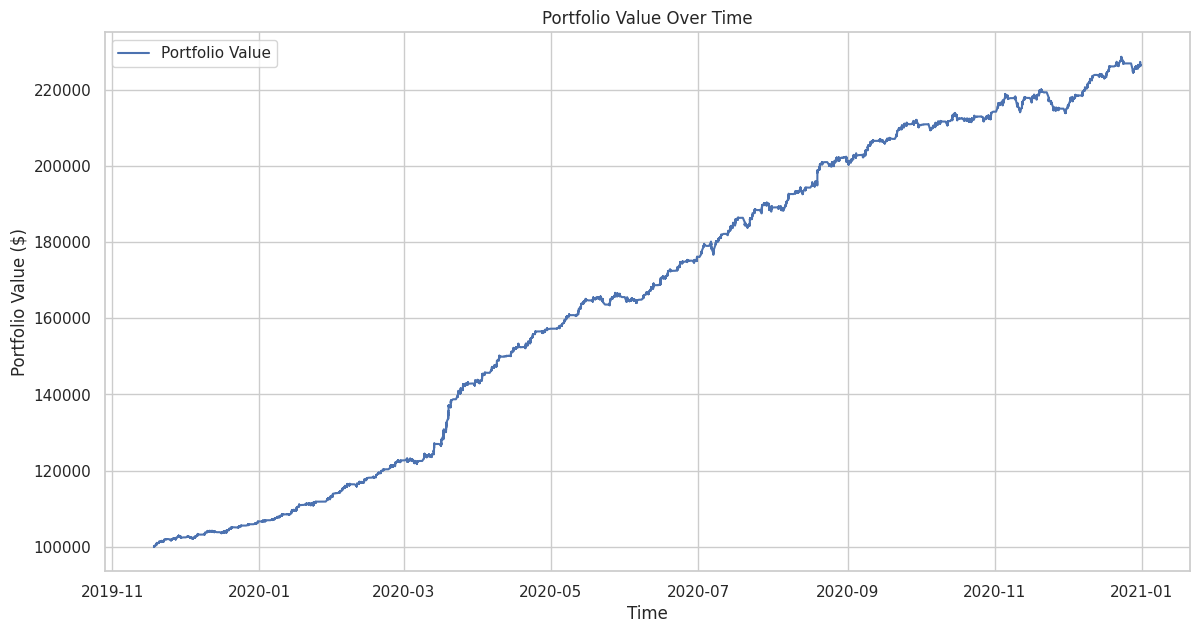

Final Portfolio Value: $226360.32
Cumulative Strategy Return: 126.36%
Cumulative Market Return: 1.94%


In [34]:
import matplotlib.pyplot as plt

# Assume initial capital of $100,000
initial_capital = 100000

# Calculate the daily returns of X_ASK and Y_BID
df['X_ASK_return'] = df['X_ASK'].pct_change()
df['Y_BID_return'] = df['Y_BID'].pct_change()

# Calculate the strategy returns
df['strategy_return'] = df['positions'].shift(1) * (df['Y_BID_return'] - df['X_ASK_return'])

# Calculate cumulative returns
df['cumulative_strategy_return'] = (df['strategy_return'] + 1).cumprod()
df['cumulative_market_return'] = (df['Y_BID_return'] + 1).cumprod()

# Calculate portfolio value
df['portfolio_value'] = initial_capital * df['cumulative_strategy_return']

# Plot the cumulative returns of the strategy and the market
plt.figure(figsize=(14, 7))
plt.plot(df['cumulative_strategy_return'], label='Strategy Return')
plt.plot(df['cumulative_market_return'], label='Market Return')
plt.title('Cumulative Returns: Strategy vs. Market')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(df['portfolio_value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Display the final portfolio value and cumulative returns
final_portfolio_value = df['portfolio_value'].iloc[-1]
final_strategy_return = df['cumulative_strategy_return'].iloc[-1] - 1
final_market_return = df['cumulative_market_return'].iloc[-1] - 1

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Cumulative Strategy Return: {final_strategy_return * 100:.2f}%")
print(f"Cumulative Market Return: {final_market_return * 100:.2f}%")



These results indicate that the pairs trading strategy significantly outperformed the market over the backtesting period. Below is the detailed interpretation of these findings.

#### Insights

1. **Strategy Performance**:
   - The strategy achieved a cumulative return of 126.36%, significantly higher than the market's cumulative return of 1.94%. This indicates that the strategy was able to exploit the mean-reverting nature of the spread effectively.

2. **Risk and Volatility**:
   - The plots of cumulative returns and portfolio value show the performance consistency and drawdowns. Understanding these aspects is crucial for risk management and strategy refinement.

3. **Scalability**:
   - The significant outperformance suggests that the strategy may be scalable, but further analysis and testing with larger capital and different market conditions are necessary.

#### Implications

- **Trading Decisions**: The results support the use of the pairs trading strategy, providing a systematic approach to exploit mean reversion in the spread between `X_ASK` and `Y_BID`.
- **Strategy Refinement**: Continuous monitoring and refinement of the entry and exit thresholds, as well as the rolling window size, can further enhance performance.
- **Risk Management**: Implementing risk management techniques, such as stop-loss orders and position sizing, can help mitigate potential losses during adverse market conditions.

The simple pairs trading strategy demonstrated strong performance during the backtesting period, significantly outperforming the market. By leveraging the mean-reverting nature of the spread and employing systematic trading rules, the strategy was able to generate substantial returns. Future steps include refining the strategy, testing under different market conditions, and implementing robust risk management practices to ensure sustainable performance.

### Performance Metrics

We use these key performance metrics commonly used in evaluating trading strategies:

1. **Total Return**: The overall return of the strategy over the entire period.

2. **Annualized Return**: The geometric average return per year.

3. **Annualized Volatility**: The standard deviation of daily returns, annualized.

4. **Sharpe Ratio**: The risk-adjusted return of the strategy.

5. **Maximum Drawdown**: The maximum observed loss from a peak to a trough of the portfolio, before a new peak is attained.

6. **Sortino Ratio**: The risk-adjusted return of the strategy, focusing on downside risk.

These metrics provide a comprehensive view of a trading strategy's performance, accounting for both return and risk.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Small epsilon to avoid division by zero
eps = 1e-5

# Total return
total_return = df['cumulative_strategy_return'].iloc[-1] - 1

# Calculate the number of trading days in 2020
df_2020 = df.loc['2020-01-01':'2020-12-31']
trading_days_2020 = df_2020['strategy_return'].count()

# Annualized return
annualized_return = ((1 + total_return) ** (252 / len(df))) - 1  # Assuming 252 trading days in a year

# Annualized volatility
annualized_volatility = df['strategy_return'].std() * np.sqrt(252) + eps  # Assuming 252 trading days in a year

# Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility

# Maximum Drawdown
running_max = df['cumulative_strategy_return'].cummax()
drawdown = df['cumulative_strategy_return'] / running_max - 1
max_drawdown = drawdown.min()

# Sortino Ratio
downside_std = df.loc[df['strategy_return'] < 0, 'strategy_return'].std() * np.sqrt(252)
sortino_ratio = annualized_return / (downside_std + eps)


# Store the performance metrics in a dictionary
performance_metrics = {
    'Total Return': total_return,
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Sortino Ratio': sortino_ratio
}

# Print the performance metrics with better formatting and interpretation
print("Performance Metrics:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.2%}" if metric != 'Sharpe Ratio' and metric != 'Sortino Ratio' else f"{metric}: {value:.2f}")

# Interpretation
print("\nInterpretation:")
print(f"Total Return: The strategy yielded a total return of {performance_metrics['Total Return']:.2%} over the entire period.")
print(f"Annualized Return: On an annualized basis, the strategy returned {performance_metrics['Annualized Return']:.2%} per year.")
print(f"Annualized Volatility: The strategy's annualized volatility, a measure of risk, is {performance_metrics['Annualized Volatility']:.2%} per year.")
print(f"Sharpe Ratio: The strategy's Sharpe Ratio, which indicates risk-adjusted return, is {performance_metrics['Sharpe Ratio']:.2f}. A higher Sharpe Ratio indicates better risk-adjusted performance.")
print(f"Max Drawdown: The maximum observed loss from peak to trough is {performance_metrics['Max Drawdown']:.2%}. Lower values are better.")
print(f"Sortino Ratio: The strategy's Sortino Ratio is {performance_metrics['Sortino Ratio']:.2f}. Higher values indicate better risk-adjusted returns focusing on downside risk.")


Performance Metrics:
Total Return: 126.36%
Annualized Return: 0.03%
Annualized Volatility: 0.15%
Sharpe Ratio: 0.19
Max Drawdown: -2.86%
Sortino Ratio: 0.19

Interpretation:
Total Return: The strategy yielded a total return of 126.36% over the entire period.
Annualized Return: On an annualized basis, the strategy returned 0.03% per year.
Annualized Volatility: The strategy's annualized volatility, a measure of risk, is 0.15% per year.
Sharpe Ratio: The strategy's Sharpe Ratio, which indicates risk-adjusted return, is 0.19. A higher Sharpe Ratio indicates better risk-adjusted performance.
Max Drawdown: The maximum observed loss from peak to trough is -2.86%. Lower values are better.
Sortino Ratio: The strategy's Sortino Ratio is 0.19. Higher values indicate better risk-adjusted returns focusing on downside risk.


This strategy is profitable but very risky as well. A low Sharpe ratio, despite having high profits, suggests that the strategy's returns are highly volatile and inconsistent. The Sharpe ratio measures risk-adjusted return, meaning it takes into account both the average return and the volatility (standard deviation) of those returns. If the returns are highly variable, the standard deviation will be high, potentially resulting in a negative Sharpe ratio even if the total profits are large.

## A Strategy to Trade on the Ratios
Trying the @Kidquant approach

This strategy involves trading based on the z-score of the spread between two correlated assets. By defining entry and exit thresholds, we can generate trading signals that indicate when to enter (buy) or exit (sell) positions. This strategy aims to exploit mean reversion by taking advantage of deviations from the historical mean spread.

### Trading Rules
1. **Entry Threshold**: 
   - **Long Position (Buy Signal)**: Enter a long position when the z-score of the spread is below a specified negative threshold, indicating the spread is lower than usual.
   - **Short Position (Sell Signal)**: Enter a short position when the z-score of the spread is above a specified positive threshold, indicating the spread is higher than usual.
2. **Exit Threshold**: 
   - Exit the position when the z-score of the spread moves closer to the mean, within a specified threshold around zero.

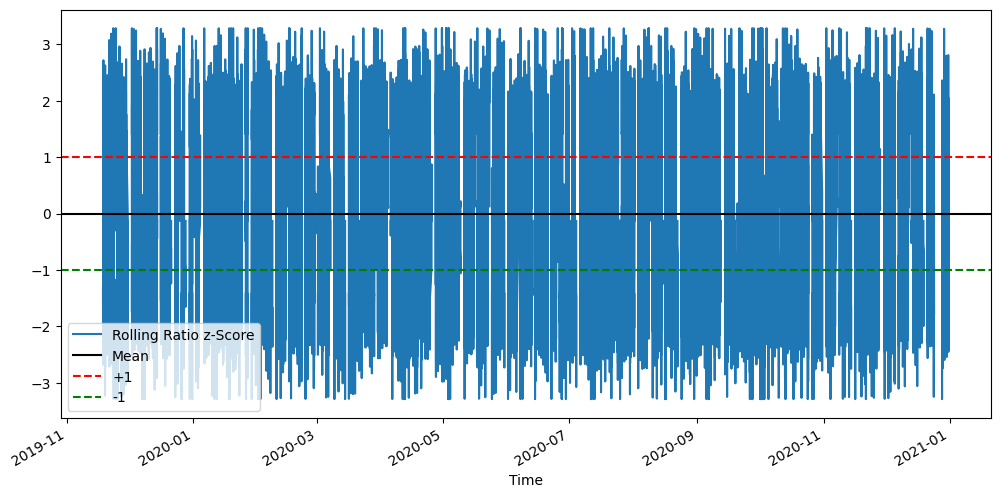

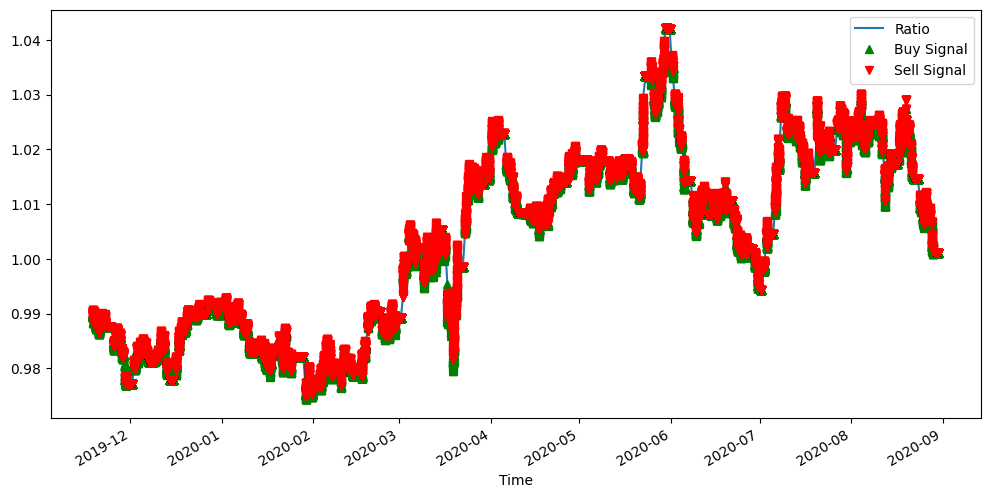

Training Profit: 1509326.7416380453
Testing Profit: 516333.4534680116
Training Sharpe Ratio: 0.03319640916686119
Testing Sharpe Ratio: 0.051148743168536466


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recontext
df['Ratio'] = df['Y_BID'] / df['X_ASK']

# Feature Engineering
df['MA_5'] = df['Ratio'].rolling(window=5, center=False).mean()
df['MA_60'] = df['Ratio'].rolling(window=60, center=False).mean()
df['STD_60'] = df['Ratio'].rolling(window=60, center=False).std()
df['Z_Score'] = (df['MA_5'] - df['MA_60']) / df['STD_60']

# Generate Trading Signals
def generate_signals(df):
    df['Signal'] = 0
    df.loc[df['Z_Score'] < -1, 'Signal'] = 1  # Buy signal
    df.loc[df['Z_Score'] > 1, 'Signal'] = -1  # Sell signal
    return df

df = generate_signals(df)

# Step 4: Train-Test Split
train_size = int(len(df) * 0.7)
train_df = df[:train_size]
test_df = df[train_size:]

# Plotting z-score and trading signals
plt.figure(figsize=(12, 6))
df['Z_Score'].plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

plt.figure(figsize=(12, 6))
train_df['Ratio'][160:].plot()
buy_signals = train_df['Ratio'].copy()
sell_signals = train_df['Ratio'].copy()
buy_signals[train_df['Z_Score'] > -1] = np.nan
sell_signals[train_df['Z_Score'] < 1] = np.nan
buy_signals[160:].plot(color='g', linestyle='None', marker='^')
sell_signals[160:].plot(color='r', linestyle='None', marker='v')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

# Trade using a simple strategy
def trade(S1, S2, window1=60, window2=5):
    if window1 == 0 or window2 == 0:
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    # Simulate trading
    money = 0
    countS1 = 0
    countS2 = 0
    interval_pnl = [0]  # Initialize with zero for the first interval
    for i in range(len(ratios)):
        if zscore.iloc[i] < -1:
            money += S1.iloc[i] - S2.iloc[i] * ratios.iloc[i]
            countS1 -= 1
            countS2 += ratios.iloc[i]
        elif zscore.iloc[i] > 1:
            money -= S1.iloc[i] - S2.iloc[i] * ratios.iloc[i]
            countS1 += 1
            countS2 -= ratios.iloc[i]
        elif abs(zscore.iloc[i]) < 0.75:
            money += S1.iloc[i] * countS1 + S2.iloc[i] * countS2
            interval_pnl.append(money)
            countS1 = 0
            countS2 = 0
        else:
            interval_pnl.append(interval_pnl[-1])
    return money, interval_pnl

# Simulate trading on train and test data
S1_train = train_df['Y_BID']
S2_train = train_df['X_ASK']
S1_test = test_df['Y_BID']
S2_test = test_df['X_ASK']

train_money, train_interval_pnl = trade(S1_train, S2_train)
test_money, test_interval_pnl = trade(S1_test, S2_test)

def calculate_sharpe_ratio(interval_pnl, EPS=1e-5):
    interval_returns = np.diff(interval_pnl) / (np.array(interval_pnl[:-1]) + EPS) # Stabilise the interval returns
    interval_returns = interval_returns[np.isfinite(interval_returns) & (interval_pnl[:-1] != 0)]  # Ensure to remove both NaN, Inf values and zero values in denominator
    if len(interval_returns) == 0:  # Avoid division by zero in case of no valid returns
        return float('nan')
    mean_return = np.mean(interval_returns)
    std_return = np.std(interval_returns)
    if std_return == 0:
        return float('nan')  # Avoid division by zero if std is zero
    sharpe_ratio = mean_return / std_return * np.sqrt(252)  # Annualized Sharpe Ratio
    return sharpe_ratio

train_sharpe_ratio = calculate_sharpe_ratio(train_interval_pnl)
test_sharpe_ratio = calculate_sharpe_ratio(test_interval_pnl)

print(f"Training Profit: {train_money}")
print(f"Testing Profit: {test_money}")
print(f"Training Sharpe Ratio: {train_sharpe_ratio}")
print(f"Testing Sharpe Ratio: {test_sharpe_ratio}")

#### Perfect, it seems like indeed this has been a great idea, as the Sharpe ratio is now positive and the profits are very large. So the Ratio is a robust signal. But this approach seems to be extremely sensitive upon the window sizes.

## My Kalman approach

dfset loaded with 737739 rows and 8 columns.


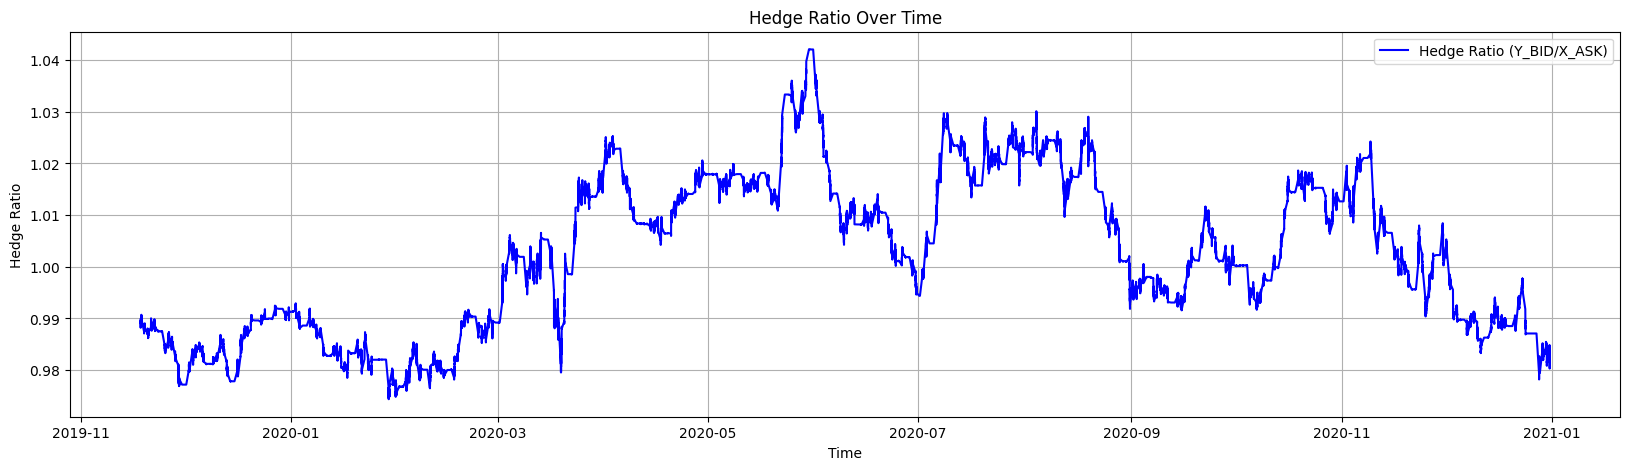

In [589]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path = 'data/final_data_10s.csv'):
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df.dropna(subset=['Time'], inplace=True)
    df.set_index('Time', inplace=True)
    print(f"dfset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

# Load your df
df = load_data()
df.index = pd.to_datetime(df.index)  # Ensure the index is datetime

class MyKalmanFilter:
    def __init__(self, delta=1e-4, R=1e-3):
        self.R = R  # Measurement noise variance
        self.Q = delta / (1 - delta) * np.eye(2)  # Covariance of process noise
        self.x = np.zeros((2, 1))  # State initialization (slope, intercept)
        self.P = np.zeros((2, 2))  # State covariance initialization

    def step_forward(self, y1, y2):
        H = np.array([y2, 1])[None]  # Observation matrix
        z = y1  # Measurement

        # Time Update (Predict)
        x_hat = self.x[:, -1][..., None]
        P_hat = self.P + self.Q

        # Measurement Update (Correct)
        K = P_hat.dot(H.T) / (H.dot(P_hat.dot(H.T)) + self.R)
        z_hat = H.dot(x_hat)
        x = x_hat + K.dot(z - z_hat)
        self.P = (np.eye(2) - K.dot(H)).dot(P_hat)
        self.x = np.concatenate([self.x, x], axis=1)

        return self.x[0, -1]  # Return the current hedge ratio, which is the slope of the linear model

# Initialize the Kalman Filter
mkf = MyKalmanFilter()

# Calculate hedge ratios
hedge_ratios = []
for index, row in df.iterrows():
    hedge_ratio = mkf.step_forward(row['Y_BID'], row['X_ASK'])
    hedge_ratios.append(hedge_ratio)

# Plot the hedge ratio over time
plt.figure(figsize=(20, 5))
plt.plot(df.index, hedge_ratios, label='Hedge Ratio (Y_BID/X_ASK)', color='blue')
plt.title('Hedge Ratio Over Time')
plt.xlabel('Time')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.grid(True)
plt.show()

The heddging ratios look very noisy and volatile

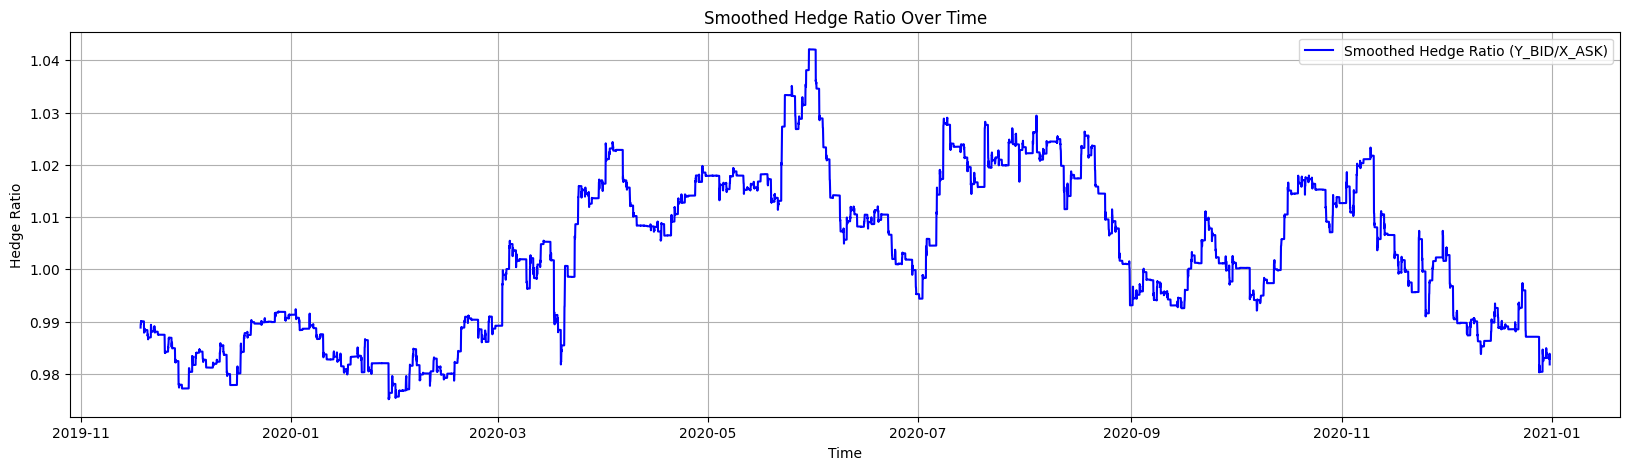

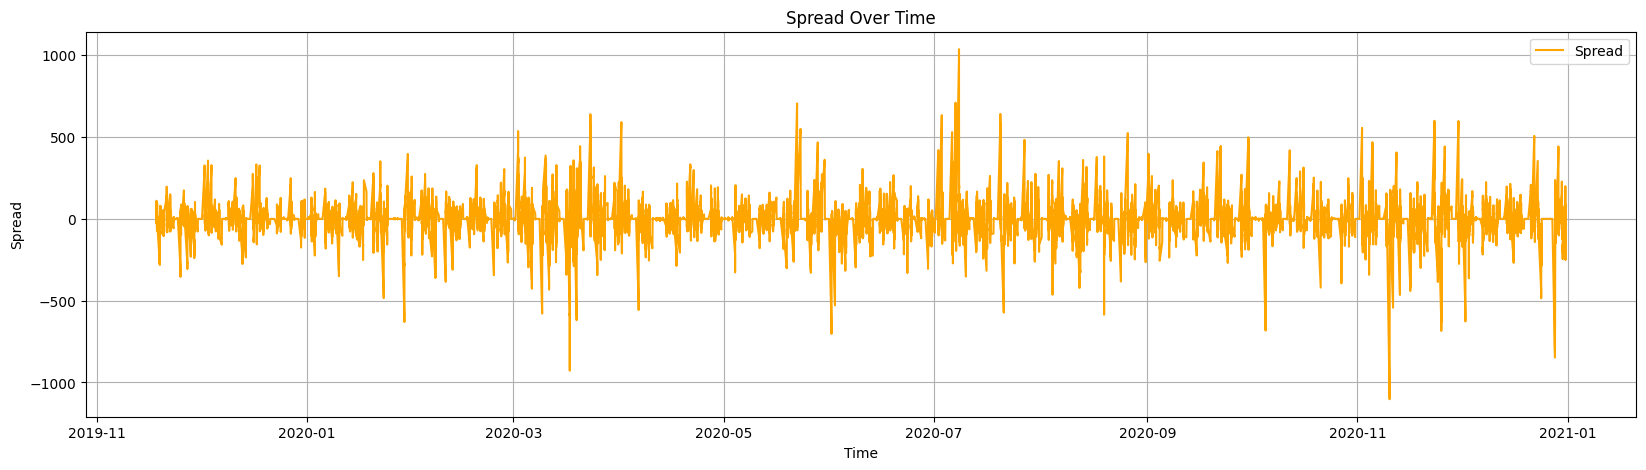

In [590]:
# Convert hedge ratios to a pandas Series
hedge_ratios = pd.Series(hedge_ratios, index=df.index)

# Smooth hedge ratios
hedge_ratios = hedge_ratios.rolling(window=360).mean()  # Example smoothing

# Plot the smoothed hedge ratio over time
plt.figure(figsize=(20, 5))
plt.plot(df.index, hedge_ratios, label='Smoothed Hedge Ratio (Y_BID/X_ASK)', color='blue')
plt.title('Smoothed Hedge Ratio Over Time')
plt.xlabel('Time')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the spread using smoothed hedge ratios
df['spread'] = df['Y_BID'] - hedge_ratios * df['X_ASK']

# Plot the spread over time
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['spread'], label='Spread', color='orange')
plt.title('Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


In [566]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the spread
df['spread'] = df['Y_BID'] - hedge_ratios * df['X_ASK']

# Check for mean reversion
result = sm.tsa.adfuller(df['spread'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -31.286878140187362
p-value: 0.0


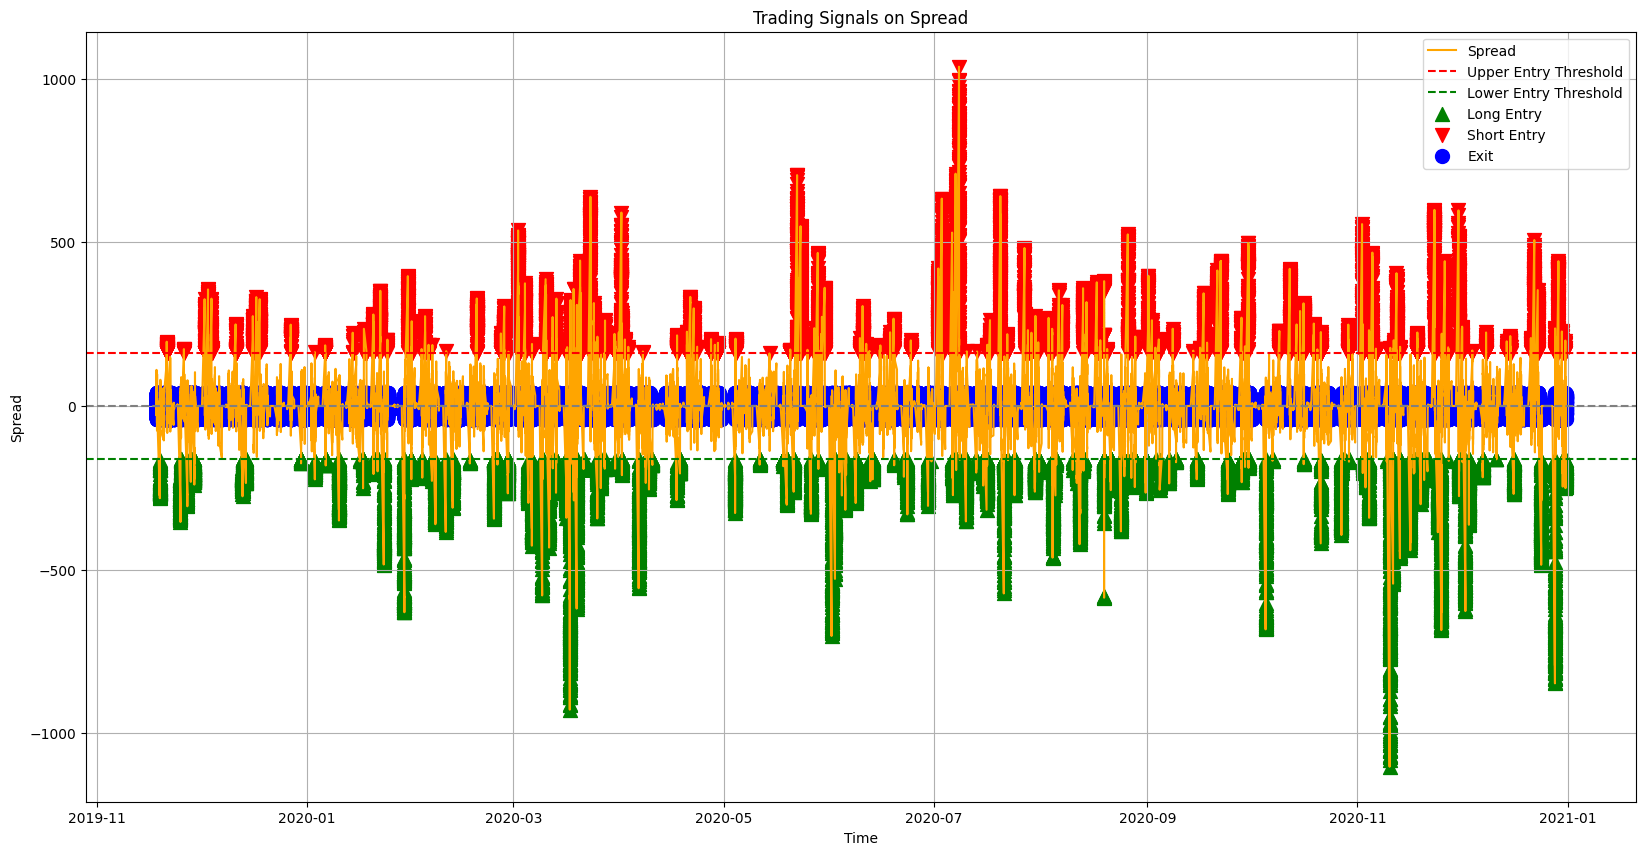

In [591]:
# Calculate mean and standard deviation of the spread
spread_mean = df['spread'].mean()
spread_std = df['spread'].std()

# Set entry and exit thresholds
entry_threshold = 2  # enter at 2 standard deviations
exit_threshold = 0.5  # exit at 0.5 standard deviation

# Generate trading signals
df['long_entry'] = df['spread'] < spread_mean - entry_threshold * spread_std
df['short_entry'] = df['spread'] > spread_mean + entry_threshold * spread_std
df['exit'] = (df['spread'] > spread_mean - exit_threshold * spread_std) & (df['spread'] < spread_mean + exit_threshold * spread_std)

# Plot entry and exit points on the spread chart
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['spread'], label='Spread', color='orange')
plt.axhline(y=spread_mean, color='gray', linestyle='--')
plt.axhline(y=spread_mean + entry_threshold * spread_std, color='red', linestyle='--', label='Upper Entry Threshold')
plt.axhline(y=spread_mean - entry_threshold * spread_std, color='green', linestyle='--', label='Lower Entry Threshold')
plt.scatter(df.index[df['long_entry']], df['spread'][df['long_entry']], color='green', marker='^', label='Long Entry', s=100)
plt.scatter(df.index[df['short_entry']], df['spread'][df['short_entry']], color='red', marker='v', label='Short Entry', s=100)
plt.scatter(df.index[df['exit']], df['spread'][df['exit']], color='blue', marker='o', label='Exit', s=100)
plt.title('Trading Signals on Spread')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

p-value < 0.05 so its mean reverting.

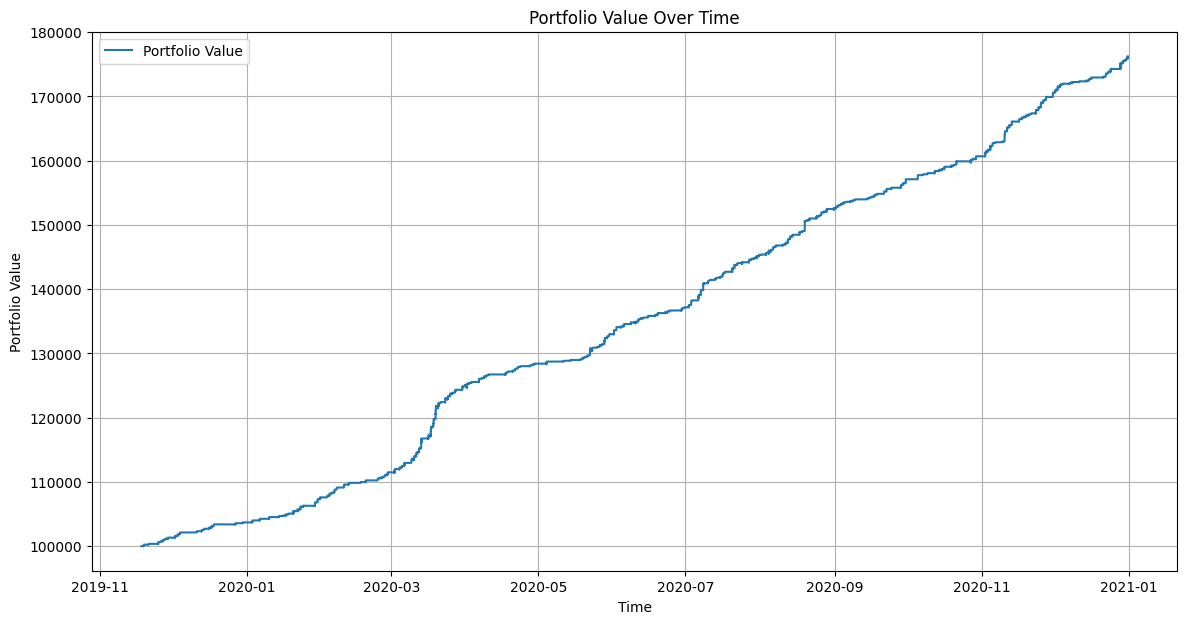

Final Portfolio Value: 176258.40945545898


In [592]:
# Initialize columns to track positions and portfolio value
df['position'] = 0  # -1 for short, 0 for neutral, 1 for long
df['portfolio_value'] = 100000  # Starting portfolio value, adjust as needed
cash = df['portfolio_value'].iloc[0]  # Starting cash

# Constants
point_value = 1  # Change based on how much one point in spread change affects the portfolio

# Iterate through the DataFrame to simulate trading
for i in range(1, len(df)):
    # Carry forward the position from the previous day if no action
    df.loc[df.index[i], 'position'] = df.loc[df.index[i-1], 'position']
    
    if df.loc[df.index[i], 'long_entry'] and df.loc[df.index[i-1], 'position'] != 1:
        df.loc[df.index[i], 'position'] = 1  # Go long
        cash -= df.loc[df.index[i], 'spread'] * point_value  # Simulate buying
    elif df.loc[df.index[i], 'short_entry'] and df.loc[df.index[i-1], 'position'] != -1:
        df.loc[df.index[i], 'position'] = -1  # Go short
        cash += df.loc[df.index[i], 'spread'] * point_value  # Simulate selling
    elif df.loc[df.index[i], 'exit']:
        if df.loc[df.index[i-1], 'position'] == 1:
            cash += df.loc[df.index[i], 'spread'] * point_value  # Close long position
        elif df.loc[df.index[i-1], 'position'] == -1:
            cash -= df.loc[df.index[i], 'spread'] * point_value  # Close short position
        df.loc[df.index[i], 'position'] = 0  # Neutral position
    
    # Update portfolio value
    position_effect = df.loc[df.index[i], 'spread'] * df.loc[df.index[i], 'position'] * point_value
    df.loc[df.index[i], 'portfolio_value'] = cash + position_effect

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['portfolio_value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Print final portfolio value
print("Final Portfolio Value:", df['portfolio_value'].iloc[-1])

In [595]:
import numpy as np

# Calculate daily returns from portfolio values
df['daily_returns'] = df['portfolio_value'].pct_change()

# Number of trading intervals per year
trading_intervals_per_year = 2340 * 252

# Annualized Returns
# Calculate the product of one plus the average returns, raised to the power of the number of intervals per year
annualized_returns = ((1 + df['daily_returns'].mean()) ** trading_intervals_per_year) - 1

# Annualized Volatility
# Standard deviation of returns multiplied by the square root of intervals per year
annualized_volatility = df['daily_returns'].std() * np.sqrt(trading_intervals_per_year)

# Risk-free rate (assuming 0 for simplification)
risk_free_rate = 0

# Sharpe Ratio
sharpe_ratio = (annualized_returns - risk_free_rate) / annualized_volatility

# Maximum Drawdown
roll_max = df['portfolio_value'].cummax()
daily_drawdown = df['portfolio_value'] / roll_max - 1.0
max_drawdown = daily_drawdown.min()

# Sortino Ratio
negative_volatility = df['daily_returns'][df['daily_returns'] < 0].std() * np.sqrt(trading_intervals_per_year)
sortino_ratio = (annualized_returns - risk_free_rate) / negative_volatility

# Print the calculated metrics
print(f"Annualized Returns: {annualized_returns * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Annualized Returns: 57.35%
Annualized Volatility: 2.20%
Sharpe Ratio: 26.05
Maximum Drawdown: -0.41%
Sortino Ratio: 11.86


Thats excellent, it means the maximum it lost at some point was 0.4% of the total gain on average at some point while making a net gains of 57% annually!